Libreries 

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from itertools import combinations
from scipy import stats
from scipy.io import loadmat, whosmat
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as sch

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

from statsmodels.multivariate.manova import MANOVA

import src
from src import config, loadmatNina
import pywt

from src.preprocessing_utils import get_envelope

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from matplotlib.patches import Ellipse

import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from scipy.linalg import inv

import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
import plotly.graph_objects as go

import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform


In [2]:
# Choose the database to analyze
database = 'DB4'

data_path = f'data/{database}'

# Find the folder named with the convention s + "number"
folder = None
for item in os.listdir(data_path):
    if re.match(r'[sS]\d+', item) or re.match(r'Subject\d+', item):
        folder = item
        break

if folder:
    folder_path = os.path.join(data_path, folder)
    results = []

    # Iterate over all .mat files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.mat'):
            file_path = os.path.join(folder_path, file_name)
            info = whosmat(file_path)
            results.append((file_name, info))

    # Create a DataFrame to store the results
    data = {}
    for file_name, info in results:
        for item in info:
            if item[0] not in data:
                data[item[0]] = {}
            data[item[0]][file_name] = item[1:]

    df = pd.DataFrame(data)
    df = df.transpose()
    df.columns.name = 'File Name'

    print(df)
else:
    print("No folder found with the convention s + 'number'")

File Name                 S1_E1_A1.mat             S1_E2_A1.mat  \
emg            ((1239383, 12), single)  ((1760957, 12), single)   
stimulus          ((1239383, 1), int8)     ((1760957, 1), int8)   
subject               ((1, 1), double)         ((1, 1), double)   
repetition        ((1239383, 1), int8)     ((1760957, 1), int8)   
age                   ((1, 1), double)         ((1, 1), double)   
exercise              ((1, 1), double)         ((1, 1), double)   
circumference         ((1, 1), double)         ((1, 1), double)   
frequency             ((1, 1), double)         ((1, 1), double)   
gender                    ((1,), char)             ((1,), char)   
height                ((1, 1), double)         ((1, 1), double)   
weight                ((1, 1), double)         ((1, 1), double)   
laterality                ((1,), char)             ((1,), char)   
sensor                    ((1,), char)             ((1,), char)   
restimulus      ((1239383, 1), double)   ((1760957, 1), double

Functions

- For complete signal

In [3]:
def calculate_emg_metrics(signal, fs=1000):
    """
    Calculates various metrics for an EMG signal.

    Parameters:
    - signal: NumPy array containing the EMG signal.
    - fs: Sampling frequency in Hz (default: 1000 Hz).

    Returns:
    - A dictionary with the computed metrics.
    """
    # Mean Absolute Value (MAV)
    mav = np.mean(np.abs(signal))
    
    # Integrated Absolute Value (IAV)
    iav = np.sum(np.abs(signal))
    
    # Root Mean Square (RMS)
    rms = np.sqrt(np.mean(signal**2))
    
    # Waveform Length (WL)
    wl = np.sum(np.abs(np.diff(signal)))
    
    # Zero Crossings (ZC)
    zc = np.sum(np.diff(np.sign(signal)) != 0)
    
    # Slope Sign Changes (SSC)
    diff_signal = np.diff(signal)
    ssc = np.sum((diff_signal[1:] * diff_signal[:-1]) < 0)
    
    # Variance (VAR)
    var = np.var(signal)
    
    # Coefficient of Variation (CoV)
    mean_signal = np.mean(signal)
    cov = (np.std(signal) / mean_signal) if mean_signal != 0 else 0
    
    # Mean Frequency (MNF)
    freqs = np.fft.rfftfreq(len(signal), d=1/fs)
    fft_magnitude = np.abs(np.fft.rfft(signal))
    mnf = np.sum(freqs * fft_magnitude) / np.sum(fft_magnitude)
    
    # Marginal Discrete Wavelet Transform (mDWT)
    coeffs = pywt.wavedec(signal, 'db4', level=4)
    mdwt = np.sum([np.sum(np.abs(c)) for c in coeffs])
    
    # Temporal Difference (TD)
    td = np.sum(np.abs(np.diff(signal)))
    
    # Mean Absolute Value Slope (MAVS)
    mavs = np.mean(np.abs(np.diff(signal)))
    
    # Return the metrics as a dictionary
    metrics = {
        "MAV": mav,
        "IAV": iav,
        "RMS": rms,
        "WL": wl,
        "ZC": zc,
        "SSC": ssc,
        "VAR": var,
        "CoV": cov,
        "MNF": mnf,
        "mDWT": mdwt,
        "TD": td,
        "MAVS": mavs
    }
    
    return metrics


- For signal with means and standard deviation

In [4]:
def calculate_emg_metrics_std(signal, fs=1000):
    """
    Calculates various metrics for an EMG signal, including mean and standard deviation.

    Parameters:
    - signal: NumPy array containing the EMG signal.
    - fs: Sampling frequency in Hz (default: 1000 Hz).

    Returns:
    - A dictionary with the computed metrics.
    """
    if signal.ndim == 2:
        metrics_per_channel = [calculate_emg_metrics(signal[:, ch], fs) for ch in range(signal.shape[1])]
        averaged_metrics = {key: np.mean([m[key] for m in metrics_per_channel]) for key in metrics_per_channel[0]}
        return averaged_metrics
    
    # Mean Absolute Value (MAV)
    mav = np.mean(np.abs(signal))
    mav_std = np.std(np.abs(signal))
    
    # Integrated Absolute Value (IAV)
    iav = np.sum(np.abs(signal))
    iav_std = np.std(np.abs(signal))
    
    # Root Mean Square (RMS)
    rms = np.sqrt(np.mean(signal**2))
    rms_std = np.std(signal)
    
    # Waveform Length (WL)
    wl = np.sum(np.abs(np.diff(signal)))
    wl_std = np.std(np.abs(np.diff(signal)))
    
    # Zero Crossings (ZC)
    zc = np.sum(np.diff(np.sign(signal)) != 0)
    zc_std = np.std(np.diff(np.sign(signal)) != 0)
    
    # Slope Sign Changes (SSC)
    diff_signal = np.diff(signal)
    ssc = np.sum((diff_signal[1:] * diff_signal[:-1]) < 0)
    ssc_std = np.std((diff_signal[1:] * diff_signal[:-1]) < 0)
    
    # Variance (VAR)
    var = np.var(signal)
    var_std = np.std(signal)
    
    # Coefficient of Variation (CoV)
    mean_signal = np.mean(signal)
    cov = (np.std(signal) / mean_signal) if mean_signal != 0 else 0
    cov_std = np.std(cov)
    
    # Mean Frequency (MNF)
    freqs = np.fft.rfftfreq(len(signal), d=1/fs)
    fft_magnitude = np.abs(np.fft.rfft(signal))
    mnf = np.sum(freqs * fft_magnitude) / np.sum(fft_magnitude)
    mnf_std = np.std(freqs * fft_magnitude) / np.sum(fft_magnitude)
    
    # Marginal Discrete Wavelet Transform (mDWT)
    coeffs = pywt.wavedec(signal, 'db4', level=4)
    mdwt = np.sum([np.sum(np.abs(c)) for c in coeffs])
    mdwt_std = np.std([np.sum(np.abs(c)) for c in coeffs])
    
    # Temporal Difference (TD)
    td = np.sum(np.abs(np.diff(signal)))
    td_std = np.std(np.abs(np.diff(signal)))
    
    # Mean Absolute Value Slope (MAVS)
    mavs = np.mean(np.abs(np.diff(signal)))
    mavs_std = np.std(np.abs(np.diff(signal)))
    
    # Return the metrics as a dictionary
    metrics = {
        "MAV": mav, "MAV_STD": mav_std,
        "IAV": iav, "IAV_STD": iav_std,
        "RMS": rms, "RMS_STD": rms_std,
        "WL": wl, "WL_STD": wl_std,
        "ZC": zc, "ZC_STD": zc_std,
        "SSC": ssc, "SSC_STD": ssc_std,
        "VAR": var, "VAR_STD": var_std,
        "CoV": cov, "CoV_STD": cov_std,
        "MNF": mnf, "MNF_STD": mnf_std,
        "mDWT": mdwt, "mDWT_STD": mdwt_std,
        "TD": td, "TD_STD": td_std,
        "MAVS": mavs, "MAVS_STD": mavs_std
    }
    
    return metrics


- This functions calculate the metrics for channel and average the values for a complete result

In [5]:
def calculate_emg_metrics_means(signal):
    """
    Calculates the metrics of an EMG signal. If there are multiple channels, it computes 
    the metrics for each channel and then averages the results.
    """
    if signal.ndim == 2:  # If the signal has multiple channels
        metrics_per_channel = [calculate_emg_metrics_means(signal[:, ch]) for ch in range(signal.shape[1])]
        averaged_metrics = {key: np.mean([m[key] for m in metrics_per_channel]) for key in metrics_per_channel[0]}
        return averaged_metrics
    
    # Mean Absolute Value (MAV)
    mav = np.mean(np.abs(signal))
    
    # Integrated Absolute Value (IAV)
    iav = np.sum(np.abs(signal))
    
    # Root Mean Square (RMS)
    rms = np.sqrt(np.mean(signal**2))
    
    # Waveform Length (WL)
    wl = np.sum(np.abs(np.diff(signal)))
    
    # Zero Crossings (ZC)
    zc = np.sum(np.diff(np.sign(signal)) != 0)
    
    # Slope Sign Changes (SSC)
    diff_signal = np.diff(signal)
    ssc = np.sum((diff_signal[1:] * diff_signal[:-1]) < 0)
    
    # Variance (VAR)
    var = np.var(signal)
    
    # Coefficient of Variation (CoV)
    mean_signal = np.mean(signal)
    cov = (np.std(signal) / mean_signal) if mean_signal != 0 else 0
    
    # Mean Frequency (MNF)
    freqs = np.fft.rfftfreq(len(signal), d=1/fs)
    fft_magnitude = np.abs(np.fft.rfft(signal))
    mnf = np.sum(freqs * fft_magnitude) / np.sum(fft_magnitude)
    
    # Marginal Discrete Wavelet Transform (mDWT)
    coeffs = pywt.wavedec(signal, 'db4', level=4)
    mdwt = np.sum([np.sum(np.abs(c)) for c in coeffs])
    
    # Temporal Difference (TD)
    td = np.sum(np.abs(np.diff(signal)))
    
    # Mean Absolute Value Slope (MAVS)
    mavs = np.mean(np.abs(np.diff(signal)))
    
    # Return the metrics as a dictionary
    metrics = {
        "MAV": mav,
        "IAV": iav,
        "RMS": rms,
        "WL": wl,
        "ZC": zc,
        "SSC": ssc,
        "VAR": var,
        "CoV": cov,
        "MNF": mnf,
        "mDWT": mdwt,
        "TD": td,
        "MAVS": mavs
    }
    
    return metrics

Plots and metrics for complete grasp


Processing: S1_E1_A1.mat
Loaded file: S1_E1_A1.mat
Total test time: 619.6915 seconds
Total test time: 10.328191666666667 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Total EMG samples: 14872596.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -8.996921e+01  0.000000e+00      1.0  0.000000e+00  29.0   
50%             NaN -4.555057e+00  3.000000e+00      1.0  2.000000e+00  29.0   
75%             NaN  7.687926e+01  8.000000e+00      1.0  4.000000e+00  29.0   
count           0.0  1.487260e+07  1.239383e+06      1.0  1.239383e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  3.011400e+04  1.200000e+01      1.0  6.000000e+00  29.0   
mean            NaN -5.482289e+00  4.090893e+00      1.0  2.203224e+00  29.0   
min             NaN -2.516700e+04  0.000000e+00      1.0  0.000000e+00  29.0   
std   

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Number of Repetitions: 0


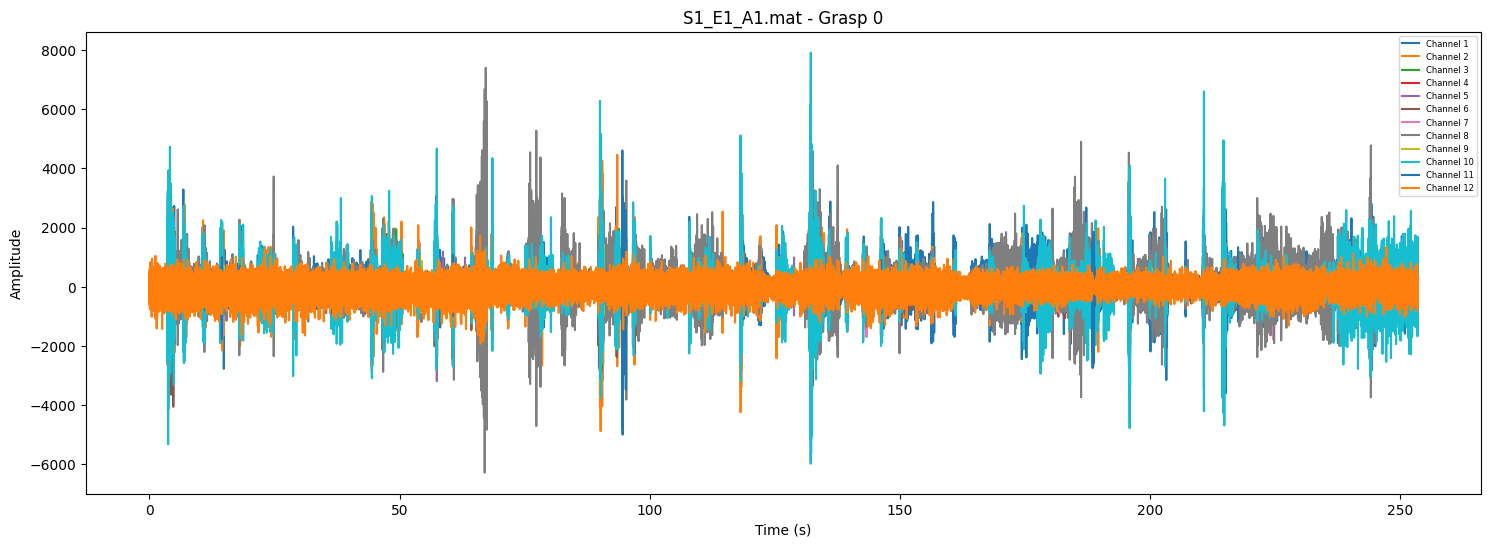

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(



Metrics for Grasp 1:
MAV: 48.4610
IAV: 581.5318
RMS: 53.2110
WL: 820.6918
ZC: 6.0000
SSC: 8.0000
VAR: 2680.6677
CoV: -4.2169
MNF: 289.0293
mDWT: 1546.8218
TD: 820.6918
MAVS: 74.6083
Rest included in the movement extraction!
Filtered EMG data shape: (96644, 12)
Filtered restimulus data shape: (96644, 1)
test time: 48.322 seconds
Number of Repetitions: 6


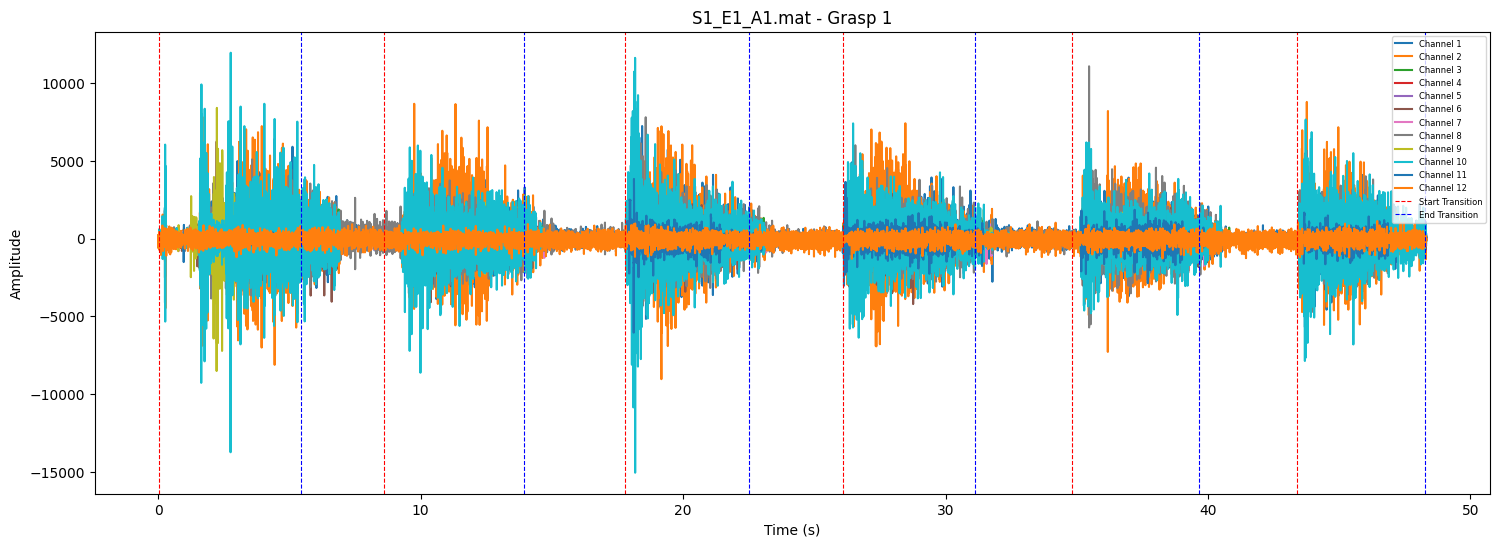

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(



Metrics for Grasp 2:
MAV: 39.8177
IAV: 477.8126
RMS: 45.3729
WL: 627.3182
ZC: 8.0000
SSC: 7.0000
VAR: 2048.7620
CoV: -14.3551
MNF: 279.5329
mDWT: 1197.2719
TD: 627.3182
MAVS: 57.0289
Rest included in the movement extraction!
Filtered EMG data shape: (97291, 12)
Filtered restimulus data shape: (97291, 1)
test time: 48.6455 seconds
Number of Repetitions: 6


KeyboardInterrupt: 

In [6]:
# Database name
database = 'DB4'

# Full path to the database folder
data_path = os.path.abspath(os.path.join('data', database))

# List of subjects, generating names from 's1' to 's10'
subjects = [f's{i}' for i in range(1, 11)]

# Iterate over each subject
for subject in subjects:
    subject_dir = os.path.join(data_path, subject)
    
    # Iterate over exercise files E1, E2, and E3 for the current subject
    for exercise in ["E1", "E2", "E3"]:
        filename = f"{subject.upper()}_{exercise}_A1.mat"
        file_path = os.path.join(subject_dir, filename)
        
        # Check if the file exists
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        
        print(f"\nProcessing: {filename}")
        
        # Load data from the .mat file
        mat_data = src.loadmatNina(database, filename, subject=subject)
        
        # Verify the structure of the loaded dictionary
        print(f"Keys in mat_data: {mat_data.keys()}")
        
        # Retrieve re-labeled data and the list of labeled grasps
        test_df, grasps_etiquetados = src.build_dataframe(
            mat_file=mat_data,
            database=database,
            filename=filename,
            rectify=False,
            normalize=True
        )
        
        # Iterate over each labeled grasp
        for grasp  in grasps_etiquetados:
            try:
                # Check if 'emg' key exists in mat_data
                if 'emg' not in mat_data:
                    raise KeyError(f"The key 'emg' is not in mat_data. Available keys: {mat_data.keys()}")
                
                # Get the EMG signal for the labeled grasp
                emg_signal = mat_data['emg'][grasp]  # Adjust based on the actual structure
                
                # Compute EMG signal metrics
                metrics = calculate_emg_metrics(emg_signal)
                
                # Print computed metrics
                print(f"\nMetrics for Grasp {grasp}:")
                for key, value in metrics.items():
                    print(f"{key}: {value:.4f}")
                
                # Plot the EMG signal for the grasp
                src.plot_emg_data(
                    database=database,
                    mat_file=mat_data,
                    grasp_number=grasp,
                    interactive=False,
                    include_rest=True,
                    use_stimulus=False,
                    addFourier=False,
                    padding=100,
                    title=f"{filename} - Grasp {grasp}"
                )
            except KeyError as e:
                print(f"    Error: {str(e)}")
            except Exception as e:
                print(f"    Error processing grasp {grasp}: {str(e)}")
                continue


In [ ]:
display(mat_data)

Dataframe with metrics for a complete signal without discriminating by channel

In [7]:
# Database name
database = 'DB4'

# Full path to the database folder
data_path = os.path.abspath(os.path.join('data', database))

# List of subjects, generating names from 's1' to 's10'
subjects = [f's{i}' for i in range(1, 11)]

# List to store all extracted metrics
metrics_data = []

# Iterate over each subject in the database
for subject in subjects:
    subject_dir = os.path.join(data_path, subject)
    
    # Iterate over exercise files E1, E2, and E3
    for exercise in ["E1", "E2", "E3"]:
        filename = f"{subject.upper()}_{exercise}_A1.mat"
        file_path = os.path.join(subject_dir, filename)
        
        # Check if the file exists before processing
        if not os.path.exists(file_path):
            continue  # Skip if file is not available
        
        # Load data from the .mat file
        mat_data = src.loadmatNina(database, filename, subject=subject)
        
        # Build DataFrame with re-labeled data
        test_df, grasps_etiquetados = src.build_dataframe(
            mat_file=mat_data,
            database=database,
            filename=filename,
            rectify=False,
            normalize=True
        )
        
        # Iterate over labeled grasps
        for grasp in grasps_etiquetados:
            try:
                # Retrieve the corresponding EMG signal
                emg_signal = mat_data['emg'][grasp]
                
                # Compute EMG signal metrics
                metrics = calculate_emg_metrics(emg_signal)
                
                # Append metrics with metadata to the list
                metrics_data.append({
                    "subject": subject,
                    "exercise": exercise,
                    "filename": filename,
                    "grasp": grasp,
                    **metrics  # Unpack metrics into the dictionary
                })
                
            except Exception as e:
                print(f"Error in {filename} - Grasp {grasp}: {str(e)}")
                continue

# Create a DataFrame with organized metrics
metrics_df = pd.DataFrame(metrics_data)

# Reorder columns (optional) for better visualization
column_order = ["subject", "exercise", "filename", "grasp"] + list(metrics.keys())
metrics_df = metrics_df[column_order]

# Print the final DataFrame with extracted metrics
print("\nMetrics DataFrame:")
metrics_df

Loaded file: S1_E1_A1.mat
Total test time: 619.6915 seconds
Total test time: 10.328191666666667 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Total EMG samples: 14872596.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -8.996921e+01  0.000000e+00      1.0  0.000000e+00  29.0   
50%             NaN -4.555057e+00  3.000000e+00      1.0  2.000000e+00  29.0   
75%             NaN  7.687926e+01  8.000000e+00      1.0  4.000000e+00  29.0   
count           0.0  1.487260e+07  1.239383e+06      1.0  1.239383e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  3.011400e+04  1.200000e+01      1.0  6.000000e+00  29.0   
mean            NaN -5.482289e+00  4.090893e+00      1.0  2.203224e+00  29.0   
min             NaN -2.516700e+04  0.000000e+00      1.0  0.000000e+00  29.0   
std             NaN  7.292349e+0

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S1_E2_A1.mat
Total test time: 880.4785 seconds
Total test time: 14.674641666666668 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Total EMG samples: 21131484.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -8.209941e+01  0.000000e+00      1.0  0.000000e+00  29.0   
50%             NaN -4.404251e+00  4.000000e+00      1.0  2.000000e+00  29.0   
75%             NaN  7.037823e+01  1.100000e+01      1.0  4.000000e+00  29.0   
count           0.0  2.113148e+07  1.760957e+06      1.0  1.760957e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  2.426700e+04  1.700000e+01      1.0  6.000000e+00  29.0   
mean            NaN -5.337770e+00  5.654732e+00      1.0  2.200919e+00  29.0   
min             NaN -2.329500e+04  0.000000e+00      1.0  0.000000e+00  29.0   
std             N

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S1_E3_A1.mat
Total test time: 1237.1735 seconds
Total test time: 20.619558333333334 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Total EMG samples: 29692164.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -7.492087e+01  0.000000e+00      1.0  0.000000e+00  29.0   
50%             NaN -4.665030e+00  4.000000e+00      1.0  2.000000e+00  29.0   
75%             NaN  6.304876e+01  1.400000e+01      1.0  4.000000e+00  29.0   
count           0.0  2.969216e+07  2.474347e+06      1.0  2.474347e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  1.740000e+04  2.300000e+01      1.0  6.000000e+00  29.0   
mean            NaN -5.448004e+00  7.233709e+00      1.0  2.110377e+00  29.0   
min             NaN -1.835400e+04  0.000000e+00      1.0  0.000000e+00  29.0  

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S2_E1_A1.mat
Total test time: 619.859 seconds
Total test time: 10.330983333333334 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Total EMG samples: 14876616.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -7.054953e+01  0.000000e+00      2.0  0.000000e+00  27.0   
50%             NaN -1.941422e+00  3.000000e+00      2.0  2.000000e+00  27.0   
75%             NaN  6.348642e+01  8.000000e+00      2.0  4.000000e+00  27.0   
count           0.0  1.487662e+07  1.239718e+06      1.0  1.239718e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  3.232000e+04  1.200000e+01      2.0  6.000000e+00  27.0   
mean            NaN -4.155154e+00  4.087990e+00      2.0  2.201260e+00  27.0   
min             NaN -3.276700e+04  0.000000e+00      2.0  0.000000e+00  27.0   
std             NaN  4.222994e+02

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S2_E2_A1.mat
Total test time: 878.6905 seconds
Total test time: 14.644841666666668 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Total EMG samples: 21088572.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -6.456418e+01  0.000000e+00      2.0  0.000000e+00  27.0   
50%             NaN -2.992639e+00  4.000000e+00      2.0  2.000000e+00  27.0   
75%             NaN  5.647842e+01  1.100000e+01      2.0  4.000000e+00  27.0   
count           0.0  2.108857e+07  1.757381e+06      1.0  1.757381e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  3.098500e+04  1.700000e+01      2.0  6.000000e+00  27.0   
mean            NaN -4.161563e+00  5.658299e+00      2.0  2.202603e+00  27.0   
min             NaN -2.097100e+04  0.000000e+00      2.0  0.000000e+00  27.0   
std             N

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S2_E3_A1.mat
Total test time: 1238.0355 seconds
Total test time: 20.633924999999998 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Total EMG samples: 29712852.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -5.481822e+01  0.000000e+00      2.0  0.000000e+00  27.0   
50%             NaN -3.313692e+00  4.000000e+00      2.0  2.000000e+00  27.0   
75%             NaN  4.672344e+01  1.400000e+01      2.0  4.000000e+00  27.0   
count           0.0  2.971285e+07  2.476071e+06      1.0  2.476071e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  1.360100e+04  2.300000e+01      2.0  6.000000e+00  27.0   
mean            NaN -3.943152e+00  7.232033e+00      2.0  2.110116e+00  27.0   
min             NaN -8.563732e+03  0.000000e+00      2.0  0.000000e+00  27.0  

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S3_E1_A1.mat
Total test time: 619.9355 seconds
Total test time: 10.332258333333334 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Total EMG samples: 14878452.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__   age  circumference           emg  exercise  frequency  \
25%             NaN  30.0           28.0 -4.930469e+01       2.0     2000.0   
50%             NaN  30.0           28.0 -1.251826e+00       2.0     2000.0   
75%             NaN  30.0           28.0  4.579725e+01       2.0     2000.0   
count           0.0   1.0            1.0  1.487845e+07       1.0        1.0   
freq            NaN   NaN            NaN           NaN       NaN        NaN   
max             NaN  30.0           28.0  1.305900e+04       2.0     2000.0   
mean            NaN  30.0           28.0 -3.598027e+00       2.0     2000.0   
min             NaN  30.0           28.0 -1.747600e+04       2.0     2000.0   
std             NaN   NaN            NaN 

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S3_E2_A1.mat
Total test time: 878.945 seconds
Total test time: 14.649083333333333 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Total EMG samples: 21094680.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -5.261013e+01  0.000000e+00      3.0  0.000000e+00  30.0   
50%             NaN -1.891787e+00  4.000000e+00      3.0  2.000000e+00  30.0   
75%             NaN  4.828047e+01  1.100000e+01      3.0  4.000000e+00  30.0   
count           0.0  2.109468e+07  1.757890e+06      1.0  1.757890e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  1.887100e+04  1.700000e+01      3.0  6.000000e+00  30.0   
mean            NaN -3.949792e+00  5.659140e+00      3.0  2.204355e+00  30.0   
min             NaN -3.268207e+04  0.000000e+00      3.0  0.000000e+00  30.0   
std             Na

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S3_E3_A1.mat
Total test time: 1237.4135 seconds
Total test time: 20.623558333333335 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Total EMG samples: 29697924.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__   age  circumference           emg  exercise  frequency  \
25%             NaN  30.0           28.0 -4.681919e+01       3.0     2000.0   
50%             NaN  30.0           28.0 -2.036133e+00       3.0     2000.0   
75%             NaN  30.0           28.0  4.211128e+01       3.0     2000.0   
count           0.0   1.0            1.0  2.969792e+07       1.0        1.0   
freq            NaN   NaN            NaN           NaN       NaN        NaN   
max             NaN  30.0           28.0  3.200000e+04       3.0     2000.0   
mean            NaN  30.0           28.0 -3.778960e+00       3.0     2000.0   
min             NaN  30.0           28.0 -2.299000e+04       3.0     2000.0   
std    

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S4_E1_A1.mat
Total test time: 621.283 seconds
Total test time: 10.354716666666667 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Total EMG samples: 14910792.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -6.107870e+01  0.000000e+00      4.0  0.000000e+00  54.0   
50%             NaN -5.000000e+00  3.000000e+00      4.0  2.000000e+00  54.0   
75%             NaN  4.990728e+01  8.000000e+00      4.0  4.000000e+00  54.0   
count           0.0  1.491079e+07  1.242566e+06      1.0  1.242566e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  3.251200e+04  1.200000e+01      4.0  6.000000e+00  54.0   
mean            NaN -5.824373e+00  4.081255e+00      4.0  2.196725e+00  54.0   
min             NaN -2.629578e+04  0.000000e+00      4.0  0.000000e+00  54.0   
std             NaN  2.997660e+02

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S4_E2_A1.mat
Total test time: 878.599 seconds
Total test time: 14.643316666666667 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Total EMG samples: 21086376.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -6.607728e+01  0.000000e+00      4.0  0.000000e+00  54.0   
50%             NaN -5.397935e+00  4.000000e+00      4.0  2.000000e+00  54.0   
75%             NaN  5.407066e+01  1.100000e+01      4.0  4.000000e+00  54.0   
count           0.0  2.108638e+07  1.757198e+06      1.0  1.757198e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  3.244800e+04  1.700000e+01      4.0  6.000000e+00  54.0   
mean            NaN -6.304722e+00  5.661533e+00      4.0  2.204705e+00  54.0   
min             NaN -1.800500e+04  0.000000e+00      4.0  0.000000e+00  54.0   
std             Na

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S4_E3_A1.mat
Total test time: 1237.3745 seconds
Total test time: 20.62290833333333 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Total EMG samples: 29696988.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -6.474970e+01  0.000000e+00      4.0  0.000000e+00  54.0   
50%             NaN -4.881322e+00  4.000000e+00      4.0  2.000000e+00  54.0   
75%             NaN  5.393970e+01  1.400000e+01      4.0  4.000000e+00  54.0   
count           0.0  2.969699e+07  2.474749e+06      1.0  2.474749e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  2.880000e+04  2.300000e+01      4.0  6.000000e+00  54.0   
mean            NaN -5.814849e+00  7.230397e+00      4.0  2.110057e+00  54.0   
min             NaN -2.215900e+04  0.000000e+00      4.0  0.000000e+00  54.0   

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S5_E1_A1.mat
Total test time: 619.8235 seconds
Total test time: 10.330391666666666 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Total EMG samples: 14875764.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -4.306354e+01  0.000000e+00      5.0  0.000000e+00  20.0   
50%             NaN -1.893583e+00  3.000000e+00      5.0  2.000000e+00  20.0   
75%             NaN  3.860566e+01  8.000000e+00      5.0  4.000000e+00  20.0   
count           0.0  1.487576e+07  1.239647e+06      1.0  1.239647e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  8.326000e+03  1.200000e+01      5.0  6.000000e+00  20.0   
mean            NaN -2.819532e+00  4.090657e+00      5.0  2.201788e+00  20.0   
min             NaN -8.503000e+03  0.000000e+00      5.0  0.000000e+00  20.0   
std             NaN  2.234214e+0

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S5_E2_A1.mat
Total test time: 878.852 seconds
Total test time: 14.647533333333334 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Total EMG samples: 21092448.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -4.587512e+01  0.000000e+00      5.0  0.000000e+00  20.0   
50%             NaN -2.311964e+00  4.000000e+00      5.0  2.000000e+00  20.0   
75%             NaN  4.034189e+01  1.100000e+01      5.0  4.000000e+00  20.0   
count           0.0  2.109245e+07  1.757704e+06      1.0  1.757704e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  1.399300e+04  1.700000e+01      5.0  6.000000e+00  20.0   
mean            NaN -3.500047e+00  5.661146e+00      5.0  2.203077e+00  20.0   
min             NaN -1.355500e+04  0.000000e+00      5.0  0.000000e+00  20.0   
std             Na

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S5_E3_A1.mat
Total test time: 1237.1345 seconds
Total test time: 20.61890833333333 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Total EMG samples: 29691228.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -4.705807e+01  0.000000e+00      5.0  0.000000e+00  20.0   
50%             NaN -2.177381e+00  4.000000e+00      5.0  2.000000e+00  20.0   
75%             NaN  4.169695e+01  1.400000e+01      5.0  4.000000e+00  20.0   
count           0.0  2.969123e+07  2.474269e+06      1.0  2.474269e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  1.138500e+04  2.300000e+01      5.0  6.000000e+00  20.0   
mean            NaN -3.625164e+00  7.233487e+00      5.0  2.110921e+00  20.0   
min             NaN -1.196600e+04  0.000000e+00      5.0  0.000000e+00  20.0   

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S6_E1_A1.mat
Total test time: 620.065 seconds
Total test time: 10.334416666666668 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Total EMG samples: 14881560.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -5.685962e+01  0.000000e+00      6.0  0.000000e+00  25.0   
50%             NaN -2.294654e+00  3.000000e+00      6.0  2.000000e+00  25.0   
75%             NaN  5.227180e+01  8.000000e+00      6.0  4.000000e+00  25.0   
count           0.0  1.488156e+07  1.240130e+06      1.0  1.240130e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  1.058500e+04  1.200000e+01      6.0  6.000000e+00  25.0   
mean            NaN -4.297639e+00  4.091364e+00      6.0  2.202627e+00  25.0   
min             NaN -1.082800e+04  0.000000e+00      6.0  0.000000e+00  25.0   
std             NaN  2.285841e+02

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S6_E2_A1.mat
Total test time: 878.8875 seconds
Total test time: 14.648125 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Total EMG samples: 21093300.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -6.875542e+01  0.000000e+00      6.0  0.000000e+00  25.0   
50%             NaN -3.445991e+00  4.000000e+00      6.0  2.000000e+00  25.0   
75%             NaN  6.149396e+01  1.100000e+01      6.0  4.000000e+00  25.0   
count           0.0  2.109330e+07  1.757775e+06      1.0  1.757775e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  2.155200e+04  1.700000e+01      6.0  6.000000e+00  25.0   
mean            NaN -5.547940e+00  5.661852e+00      6.0  2.204558e+00  25.0   
min             NaN -2.204100e+04  0.000000e+00      6.0  0.000000e+00  25.0   
std             NaN  3.737

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S6_E3_A1.mat
Total test time: 1237.792 seconds
Total test time: 20.629866666666665 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Total EMG samples: 29707008.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -6.118375e+01  0.000000e+00      6.0  0.000000e+00  25.0   
50%             NaN -3.324570e+00  4.000000e+00      6.0  2.000000e+00  25.0   
75%             NaN  5.464680e+01  1.400000e+01      6.0  4.000000e+00  25.0   
count           0.0  2.970701e+07  2.475584e+06      1.0  2.475584e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  1.491961e+04  2.300000e+01      6.0  6.000000e+00  25.0   
mean            NaN -5.185667e+00  7.234566e+00      6.0  2.111741e+00  25.0   
min             NaN -1.379000e+04  0.000000e+00      6.0  0.000000e+00  25.0   

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S7_E1_A1.mat
Total test time: 619.579 seconds
Total test time: 10.326316666666665 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Total EMG samples: 14869896.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__   age  circumference           emg  exercise  frequency  \
25%             NaN  30.0           27.0 -7.945179e+01       2.0     2000.0   
50%             NaN  30.0           27.0 -6.691616e+00       2.0     2000.0   
75%             NaN  30.0           27.0  6.194468e+01       2.0     2000.0   
count           0.0   1.0            1.0  1.486990e+07       1.0        1.0   
freq            NaN   NaN            NaN           NaN       NaN        NaN   
max             NaN  30.0           27.0  2.267400e+04       2.0     2000.0   
mean            NaN  30.0           27.0 -5.450195e+00       2.0     2000.0   
min             NaN  30.0           27.0 -2.790600e+04       2.0     2000.0   
std             NaN   NaN            NaN  

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S7_E2_A1.mat
Total test time: 878.9565 seconds
Total test time: 14.649275 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Total EMG samples: 21094956.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -5.949966e+01  0.000000e+00      7.0  0.000000e+00  30.0   
50%             NaN -4.686265e+00  4.000000e+00      7.0  2.000000e+00  30.0   
75%             NaN  4.808949e+01  1.100000e+01      7.0  4.000000e+00  30.0   
count           0.0  2.109496e+07  1.757913e+06      1.0  1.757913e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  2.848300e+04  1.700000e+01      7.0  6.000000e+00  30.0   
mean            NaN -4.854012e+00  5.658071e+00      7.0  2.202540e+00  30.0   
min             NaN -2.765900e+04  0.000000e+00      7.0  0.000000e+00  30.0   
std             NaN  5.540

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S7_E3_A1.mat
Total test time: 1237.4675 seconds
Total test time: 20.624458333333333 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Total EMG samples: 29699220.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -5.900000e+01  0.000000e+00      7.0  0.000000e+00  30.0   
50%             NaN -4.975094e+00  4.000000e+00      7.0  2.000000e+00  30.0   
75%             NaN  4.682431e+01  1.400000e+01      7.0  4.000000e+00  30.0   
count           0.0  2.969922e+07  2.474935e+06      1.0  2.474935e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  3.212800e+04  2.300000e+01      7.0  6.000000e+00  30.0   
mean            NaN -4.829390e+00  7.232712e+00      7.0  2.110220e+00  30.0   
min             NaN -2.562100e+04  0.000000e+00      7.0  0.000000e+00  30.0  

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S8_E1_A1.mat
Total test time: 619.7705 seconds
Total test time: 10.329508333333333 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Total EMG samples: 14874492.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -5.300000e+01  0.000000e+00      8.0  0.000000e+00  23.0   
50%             NaN -3.727348e+00  3.000000e+00      8.0  2.000000e+00  23.0   
75%             NaN  4.500000e+01  8.000000e+00      8.0  4.000000e+00  23.0   
count           0.0  1.487449e+07  1.239541e+06      1.0  1.239541e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  2.158000e+04  1.200000e+01      8.0  6.000000e+00  23.0   
mean            NaN -4.749814e+00  4.093060e+00      8.0  2.202908e+00  23.0   
min             NaN -2.701700e+04  0.000000e+00      8.0  0.000000e+00  23.0   
std             NaN  4.798442e+0

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S8_E2_A1.mat
Total test time: 879.973 seconds
Total test time: 14.666216666666665 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Total EMG samples: 21119352.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -5.051275e+01  0.000000e+00      8.0  0.000000e+00  23.0   
50%             NaN -3.925575e+00  4.000000e+00      8.0  2.000000e+00  23.0   
75%             NaN  4.200000e+01  1.100000e+01      8.0  4.000000e+00  23.0   
count           0.0  2.111935e+07  1.759946e+06      1.0  1.759946e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  3.161300e+04  1.700000e+01      8.0  6.000000e+00  23.0   
mean            NaN -4.760567e+00  5.649997e+00      8.0  2.200619e+00  23.0   
min             NaN -3.276700e+04  0.000000e+00      8.0  0.000000e+00  23.0   
std             Na

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S8_E3_A1.mat
Total test time: 1237.553 seconds
Total test time: 20.625883333333334 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Total EMG samples: 29701272.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -5.151678e+01  0.000000e+00      8.0  0.000000e+00  23.0   
50%             NaN -4.042775e+00  4.000000e+00      8.0  2.000000e+00  23.0   
75%             NaN  4.256739e+01  1.400000e+01      8.0  4.000000e+00  23.0   
count           0.0  2.970127e+07  2.475106e+06      1.0  2.475106e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  3.244800e+04  2.300000e+01      8.0  6.000000e+00  23.0   
mean            NaN -5.091682e+00  7.229968e+00      8.0  2.110676e+00  23.0   
min             NaN -3.276700e+04  0.000000e+00      8.0  0.000000e+00  23.0   

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S9_E1_A1.mat
Total test time: 619.4685 seconds
Total test time: 10.324475 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Total EMG samples: 14867244.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -4.390822e+01  0.000000e+00      9.0  0.000000e+00  31.0   
50%             NaN -2.539718e+00  3.000000e+00      9.0  2.000000e+00  31.0   
75%             NaN  3.810591e+01  8.000000e+00      9.0  4.000000e+00  31.0   
count           0.0  1.486724e+07  1.238937e+06      1.0  1.238937e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  1.421700e+04  1.200000e+01      9.0  6.000000e+00  31.0   
mean            NaN -3.683183e+00  4.089675e+00      9.0  2.201153e+00  31.0   
min             NaN -9.545000e+03  0.000000e+00      9.0  0.000000e+00  31.0   
std             NaN  2.853329e+02  4.1648

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S9_E2_A1.mat
Total test time: 878.9995 seconds
Total test time: 14.649991666666667 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Total EMG samples: 21095988.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -4.200000e+01  0.000000e+00      9.0  0.000000e+00  31.0   
50%             NaN -3.000000e+00  4.000000e+00      9.0  2.000000e+00  31.0   
75%             NaN  3.526757e+01  1.100000e+01      9.0  4.000000e+00  31.0   
count           0.0  2.109599e+07  1.757999e+06      1.0  1.757999e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  1.923700e+04  1.700000e+01      9.0  6.000000e+00  31.0   
mean            NaN -3.957446e+00  5.663036e+00      9.0  2.202885e+00  31.0   
min             NaN -1.952600e+04  0.000000e+00      9.0  0.000000e+00  31.0   
std             N

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S9_E3_A1.mat
Total test time: 1237.731 seconds
Total test time: 20.62885 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Total EMG samples: 29705544.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -4.139199e+01  0.000000e+00      9.0  0.000000e+00  31.0   
50%             NaN -2.690566e+00  4.000000e+00      9.0  2.000000e+00  31.0   
75%             NaN  3.526582e+01  1.400000e+01      9.0  4.000000e+00  31.0   
count           0.0  2.970554e+07  2.475462e+06      1.0  2.475462e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  9.283000e+03  2.300000e+01      9.0  6.000000e+00  31.0   
mean            NaN -3.739272e+00  7.230680e+00      9.0  2.110171e+00  31.0   
min             NaN -9.547000e+03  0.000000e+00      9.0  0.000000e+00  31.0   
std      

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S10_E1_A1.mat
Total test time: 619.628 seconds
Total test time: 10.327133333333334 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Total EMG samples: 14871072.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -1.030000e+02  0.000000e+00     10.0  0.000000e+00  27.0   
50%             NaN -4.881151e+00  3.000000e+00     10.0  2.000000e+00  27.0   
75%             NaN  9.004477e+01  8.000000e+00     10.0  4.000000e+00  27.0   
count           0.0  1.487107e+07  1.239256e+06      1.0  1.239256e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  2.804400e+04  1.200000e+01     10.0  6.000000e+00  27.0   
mean            NaN -5.773477e+00  4.088850e+00     10.0  2.202958e+00  27.0   
min             NaN -2.343600e+04  0.000000e+00     10.0  0.000000e+00  27.0   
std             NaN  7.483578e+0

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S10_E2_A1.mat
Total test time: 880.323 seconds
Total test time: 14.67205 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Total EMG samples: 21127752.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -1.001303e+02  0.000000e+00     10.0  0.000000e+00  27.0   
50%             NaN -6.181013e+00  4.000000e+00     10.0  2.000000e+00  27.0   
75%             NaN  8.500000e+01  1.100000e+01     10.0  4.000000e+00  27.0   
count           0.0  2.112775e+07  1.760646e+06      1.0  1.760646e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  3.159100e+04  1.700000e+01     10.0  6.000000e+00  27.0   
mean            NaN -6.686151e+00  5.655798e+00     10.0  2.202384e+00  27.0   
min             NaN -2.950400e+04  0.000000e+00     10.0  0.000000e+00  27.0   
std             NaN  6.8469

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Loaded file: S10_E3_A1.mat
Total test time: 1237.5515 seconds
Total test time: 20.625858333333333 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Total EMG samples: 29701236.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__   age  circumference           emg  exercise  frequency  \
25%             NaN  27.0           24.5 -7.702003e+01       3.0     2000.0   
50%             NaN  27.0           24.5 -4.892532e+00       3.0     2000.0   
75%             NaN  27.0           24.5  6.500000e+01       3.0     2000.0   
count           0.0   1.0            1.0  2.970124e+07       1.0        1.0   
freq            NaN   NaN            NaN           NaN       NaN        NaN   
max             NaN  27.0           24.5  2.172300e+04       3.0     2000.0   
mean            NaN  27.0           24.5 -5.821329e+00       3.0     2000.0   
min             NaN  27.0           24.5 -2.164300e+04       3.0     2000.0   
std   

c:\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


,subject,exercise,filename,grasp,MAV,IAV,RMS,WL,ZC,SSC,VAR,CoV,MNF,mDWT,TD,MAVS
0,s1,E1,S1_E1_A1.mat,0,51.072292,612.867493,57.002491,536.550354,4,7,3239.310547,18.022436,213.961802,1967.989014,536.550354,48.777306
1,s1,E1,S1_E1_A1.mat,1,48.460983,581.531799,53.211044,820.691772,6,8,2680.667725,-4.216925,289.029270,1546.821777,820.691772,74.608345
2,s1,E1,S1_E1_A1.mat,2,39.817715,477.812561,45.372944,627.318237,8,7,2048.761963,-14.355091,279.532948,1197.271851,627.318237,57.028931
3,s1,E1,S1_E1_A1.mat,3,28.913565,346.962769,34.297470,345.328186,3,7,1174.611328,-26.247076,243.675610,1228.901855,345.328186,31.393471
4,s1,E1,S1_E1_A1.mat,4,39.934826,479.217926,46.671608,528.163940,3,5,1958.670288,2.986725,231.864537,1208.866211,528.163940,48.014904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,s10,E3,S10_E3_A1.mat,19,167.663651,2011.963867,269.790222,2931.181152,4,5,68733.148438,4.117771,225.066140,6269.905273,2931.181152,266.471008
546,s10,E3,S10_E3_A1.mat,20,128.774979,1545.299683,207.888428,2594.574219,7,7,39569.878906,3.293607,245.830018,5463.593750,2594.574219,235.870377
547,s10,E3,S10_E3_A1.mat,21,121.593620,1459.123413,171.327240,1942.193481,5,6,23869.642578,2.086405,258.508456,6121.668457,1942.193481,176.563049
548,s10,E3,S10_E3_A1.mat,22,152.250504,1827.006104,234.368698,2405.117676,5,6,51661.722656,3.976605,278.952104,8542.379883,2405.117676,218.647064


Dataframe with average of metrics for channels in each grasp

Dataframe with mean and standard deviation

In [ ]:
# List to store all computed metrics
metrics_data = []

# Iterate over each subject in the database
for subject in subjects:
    subject_dir = os.path.join(data_path, subject)
    
    # Iterate over exercise files E1, E2, and E3
    for exercise in ["E1", "E2", "E3"]:
        filename = f"{subject.upper()}_{exercise}_A1.mat"
        file_path = os.path.join(subject_dir, filename)
        
        # Check if the file exists before processing
        if not os.path.exists(file_path):
            continue  # Skip if file is not available
        
        # Load data from the .mat file
        mat_data = src.loadmatNina(database, filename, subject=subject)
        
        # Build DataFrame with re-labeled data
        test_df, grasps_etiquetados = src.build_dataframe(
            mat_file=mat_data,
            database=database,
            filename=filename,
            rectify=False,
            normalize=True
        )
        
        # Iterate over labeled grasps
        for grasp in grasps_etiquetados:
            try:
                # Retrieve the corresponding EMG signal
                emg_signal = mat_data['emg'][grasp]
                
                # Compute EMG signal metrics using standard deviation
                metrics = calculate_emg_metrics_std(emg_signal)
                
                # Append metrics with metadata to the list
                metrics_data.append({
                    "subject": subject,
                    "exercise": exercise,
                    "filename": filename,
                    "grasp": grasp,
                    **metrics  # Unpack metrics into the dictionary
                })
                
            except Exception as e:
                print(f"Error in {filename} - Grasp {grasp}: {str(e)}")
                continue

# Create a DataFrame with organized metrics
metrics_df_std = pd.DataFrame(metrics_data)

# Reorder columns (optional) for better visualization
column_order = ["subject", "exercise", "filename", "grasp"] + list(metrics.keys())
metrics_df_std = metrics_df_std[column_order]

# Print the final DataFrame with extracted metrics
print("\nMetrics DataFrame:")
display(metrics_df_std)


Dataframe for every channels of data base

In [8]:
# List to store all generated DataFrames
all_dataframes = []

# Look for folders matching the pattern "s + number" or "Subject + number"
for folder in os.listdir(data_path):
    if re.match(r'[sS]\d+', folder) or re.match(r'Subject\d+', folder):
        folder_path = os.path.join(data_path, folder)
        
        # Iterate over all .mat files in the folder
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.mat'):
                file_path = os.path.join(folder_path, file_name)
                
                # Attempt to load the .mat file
                try:
                    mat_data = src.loadmatNina(database, file_name, subject=folder)
                except Exception as e:
                    print(f"Error loading {file_name}: {str(e)}")
                    continue
                
                # Attempt to process the file with src.build_dataframe
                try:
                    test_df, grasps = src.build_dataframe(
                        mat_file=mat_data,
                        database=database,
                        filename=file_name,
                        rectify=False,
                        normalize=True
                    )
                    
                    # Add a column with the subject name (folder) to the DataFrame
                    test_df['subject'] = folder  
                    
                    # Append the processed DataFrame to the list
                    all_dataframes.append(test_df)

                except Exception as e:
                    print(f"Error processing {file_name}: {str(e)}")
                    continue

# Concatenate all DataFrames into a single one if data is available
if all_dataframes:  
    combined_df = pd.concat(all_dataframes, ignore_index=True)
    
    # Display the combined DataFrame
    print("\n Combined DataFrame:")
    display(combined_df)  

else:
    print("Warning: No DataFrames were generated. Check the input data.")

Loaded file: S1_E1_A1.mat
Total test time: 619.6915 seconds
Total test time: 10.328191666666667 minutes
Unique restimulus values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Total EMG samples: 14872596.0
Frequency: 2000 Hz
Summary for the whole file:
        __globals__           emg      stimulus  subject    repetition   age  \
25%             NaN -8.996921e+01  0.000000e+00      1.0  0.000000e+00  29.0   
50%             NaN -4.555057e+00  3.000000e+00      1.0  2.000000e+00  29.0   
75%             NaN  7.687926e+01  8.000000e+00      1.0  4.000000e+00  29.0   
count           0.0  1.487260e+07  1.239383e+06      1.0  1.239383e+06   1.0   
freq            NaN           NaN           NaN      NaN           NaN   NaN   
max             NaN  3.011400e+04  1.200000e+01      1.0  6.000000e+00  29.0   
mean            NaN -5.482289e+00  4.090893e+00      1.0  2.203224e+00  29.0   
min             NaN -2.516700e+04  0.000000e+00      1.0  0.000000e+00  29.0   
std             NaN  7.292349e+0

,Channel 1,Channel 2,Channel 3,Channel 4,Channel 5,Channel 6,Channel 7,Channel 8,Channel 9,Channel 10,Channel 11,Channel 12,Time (s),subject,re_repetition,stimulus,relabeled
0,-0.080867,-0.026702,-0.184377,0.137110,0.139846,0.129581,0.317491,-0.030544,-0.047140,0.037009,0.227168,-0.273095,0.0000,s1,1,0,0
1,-0.015037,-0.036833,0.122537,0.289744,-0.137724,0.061688,0.185393,-0.071280,-0.062437,-0.032694,0.317192,-0.444086,0.0005,s1,1,0,0
2,-0.006427,0.005738,-0.046464,0.254572,0.123655,-0.044213,0.190557,-0.108251,-0.167532,0.018729,0.225799,-0.231815,0.0010,s1,1,0,0
3,-0.033116,-0.014365,-0.187194,-0.024231,0.042588,0.082919,0.121809,-0.071325,-0.013023,0.004729,0.233412,0.210490,0.0015,s1,1,0,0
4,-0.073164,0.055598,0.135732,0.155109,0.048102,0.080464,0.182560,-0.081284,0.030957,0.022244,0.261616,0.086686,0.0020,s1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54734064,0.526365,-0.232014,-0.144764,-1.470012,0.171508,-0.223010,-0.059488,-0.099874,-0.191369,0.430239,2.663393,-0.363635,1237.7285,s9,1,0,0
54734065,0.600321,-0.398755,0.436834,-2.025052,1.139237,-0.534930,0.284598,0.186014,-0.110955,-0.135399,1.644574,-0.142304,1237.7290,s9,1,0,0
54734066,0.883816,-0.279743,0.494179,-1.159183,0.033411,-0.403719,-0.357844,0.448696,0.062706,-0.013498,1.611724,-0.678149,1237.7295,s9,1,0,0
54734067,0.480143,-0.356353,0.960984,-0.906826,0.163598,0.356219,0.167118,0.116349,0.003835,0.241918,1.694361,-0.318103,1237.7300,s9,1,0,0


In [ ]:
# List to store all generated DataFrames
all_dataframes = []

# Look for folders matching the pattern "s + number" or "Subject + number"
for folder in os.listdir(data_path):
    if re.match(r'[sS]\d+', folder) or re.match(r'Subject\d+', folder):
        folder_path = os.path.join(data_path, folder)
        
        # Iterate over all .mat files in the folder
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.mat'):
                file_path = os.path.join(folder_path, file_name)
                
                # Attempt to load the .mat file
                try:
                    mat_data = src.loadmatNina(database, file_name, subject=folder)
                except Exception as e:
                    print(f"Error loading {file_name}: {str(e)}")
                    continue
                
                # Attempt to process the file with src.build_dataframe
                try:
                    test_df, grasps = src.build_dataframe(
                        mat_file=mat_data,
                        database=database,
                        filename=file_name,
                        rectify=False,
                        normalize=True
                    )
                    
                    # Apply envelope extraction
                    emg_columns = [col for col in test_df.columns if "Channel" in col]
                    envelope_df = get_envelope(test_df[emg_columns], envelope_type=1)  # Change type as needed
                    
                    # Preserve non-EMG columns
                    meta_columns = ["Time (s)", "subject", "re_repetition", "stimulus", "relabeled"]
                    result_df = pd.concat([envelope_df, test_df[meta_columns]], axis=1)
                    
                    # Add a column with the subject name (folder) to the DataFrame
                    result_df['subject'] = folder  
                    
                    # Append the processed DataFrame to the list
                    all_dataframes.append(result_df)
                
                except Exception as e:
                    print(f"Error processing {file_name}: {str(e)}")
                    continue

# Concatenate all DataFrames into a single one if data is available
if all_dataframes:  
    combined_df = pd.concat(all_dataframes, ignore_index=True)
    
    # Display the combined DataFrame
    print("\n Combined DataFrame:")
    display(combined_df)  

else:
    print("Warning: No DataFrames were generated. Check the input data.")

Dataframe with metrics for channel

In [ ]:
def calculate_emg_metrics(signal, fs=2000):
    """
    Calculates various metrics for an EMG signal, including mean and standard deviation.

    Parameters:
    - signal: NumPy array containing the EMG signal.
    - fs: Sampling frequency in Hz (default: 1000 Hz).

    Returns:
    - A dictionary with the computed metrics.
    """
    try:
        if signal.ndim == 2:
            metrics_per_channel = [calculate_emg_metrics(signal[:, ch], fs) for ch in range(signal.shape[1])]
            averaged_metrics = {key: np.mean([m[key] for m in metrics_per_channel]) for key in metrics_per_channel[0]}
            return averaged_metrics
        
        abs_signal = np.abs(signal)
        diff_signal = np.diff(signal)
        diff_abs_signal = np.abs(diff_signal)
        
        # Compute Metrics
        metrics = {
            "MAV": np.mean(abs_signal), "MAV_STD": np.std(abs_signal),
            "IAV": np.sum(abs_signal), "IAV_STD": np.std(abs_signal),
            "RMS": np.sqrt(np.mean(signal**2)), "RMS_STD": np.std(signal),
            "WL": np.sum(diff_abs_signal), "WL_STD": np.std(diff_abs_signal),
            "ZC": np.sum(np.diff(np.sign(signal)) != 0), "ZC_STD": np.std(np.diff(np.sign(signal)) != 0),
            "SSC": np.sum((diff_signal[1:] * diff_signal[:-1]) < 0), "SSC_STD": np.std((diff_signal[1:] * diff_signal[:-1]) < 0),
            "VAR": np.var(signal), "VAR_STD": np.std(signal),
            "CoV": (np.std(signal) / np.mean(signal)) if np.mean(signal) != 0 else 0,
            "TD": np.sum(diff_abs_signal), "TD_STD": np.std(diff_abs_signal),
            "MAVS": np.mean(diff_abs_signal), "MAVS_STD": np.std(diff_abs_signal),
            "MNP": np.mean(signal**2), "MNP_STD": np.std(signal**2),
        }
        
        # Spectral Metrics
        freqs = np.fft.rfftfreq(len(signal), d=1/fs)
        fft_magnitude = np.abs(np.fft.rfft(signal))
        metrics["MNF"] = np.sum(freqs * fft_magnitude) / np.sum(fft_magnitude) if np.sum(fft_magnitude) != 0 else 0
        metrics["MNF_STD"] = np.std(freqs * fft_magnitude) / np.sum(fft_magnitude) if np.sum(fft_magnitude) != 0 else 0
        
        # Wavelet Transform
        coeffs = pywt.wavedec(signal, 'db4', level=4)
        mdwt_values = np.array([np.sum(np.abs(c)) for c in coeffs])
        metrics["mDWT"] = np.sum(mdwt_values)
        metrics["mDWT_STD"] = np.std(mdwt_values)
        
        # Kurtosis
        std_signal = np.std(signal)
        metrics["Kurt"] = np.mean((signal - np.mean(signal)) ** 4) / (std_signal ** 4) if std_signal != 0 else 0
        metrics["Kurt_STD"] = np.std(metrics["Kurt"])
        
        return metrics
    
    except Exception as e:
        print(f"Error in calculate_emg_metrics: {e}")
        return {}

# List to store the calculated metrics for each channel
metrics_data = []

# Iterate over each subject and each identified movement (relabeled or stimulus)
for (subject, relabeled), group in combined_df.groupby(['subject', 'relabeled']):  # Change 'relabeled' to 'stimulus' if needed
    # Iterate over each EMG channel
    for channel in group.columns:  # Loop through all DataFrame columns
        if channel.startswith('Channel'):  # Filter only EMG signal columns
            # Get the signal values for the current channel
            channel_signal = group[channel].values
            
            # Compute EMG signal metrics for the current channel
            metrics = calculate_emg_metrics(channel_signal)
            
            # Append metadata and computed metrics to the list
            metrics_data.append({
                "subject": subject,  # Subject identification
                "relabeled": relabeled,  # Movement identification (relabeled or stimulus)
                "channel": channel,  # EMG channel
                **metrics  # Unpack all computed metrics
            })

# Create a DataFrame containing all the obtained metrics
metrics_df = pd.DataFrame(metrics_data)

# Reorder columns for better visualization (optional)
column_order = ["subject", "relabeled", "channel"] + list(metrics.keys())
metrics_df = metrics_df[column_order]

# Display the DataFrame with the computed metrics
print("\nMetrics DataFrame by Channel, Subject, and Relabeled:")
display(metrics_df)


In [ ]:
# Remove the 'channel' column to group data by subject and movement type
grouped_df = metrics_df.drop(columns=['channel'])

# Compute the mean value of each metric grouped by subject and movement
df_mean = grouped_df.groupby(['subject', 'relabeled']).mean()

# Compute the standard deviation of each metric grouped by subject and movement
df_std = grouped_df.groupby(['subject', 'relabeled']).std()

# Rename columns to indicate they contain mean values
df_mean.columns = [f"{col} mean" for col in df_mean.columns]

# Rename columns to indicate they contain standard deviation values
df_std.columns = [f"{col} std" for col in df_std.columns]

# Merge the mean and standard deviation DataFrames into a single DataFrame
df_result = df_mean.merge(df_std, on=['subject', 'relabeled']).reset_index()

# Display the final DataFrame with aggregated metrics
display(df_result)


Dendogram for grasp 

In [ ]:
# Select only the columns containing numerical features
features = df_result.iloc[:, 2:]  # Exclude 'subject' and 'relabeled'

# Normalize the data to improve comparability and avoid bias due to different scales
df_scaled = StandardScaler().fit_transform(features)

# Apply hierarchical clustering using the Ward method (minimizes variance within clusters)
linked = sch.linkage(df_scaled, method='ward')

# Create and visualize the dendrogram
plt.figure(figsize=(20, 10))
sch.dendrogram(
    linked, 
    labels=df_result['relabeled'].values,  # Labels on the x-axis based on the 'relabeled' variable
    leaf_rotation=90,  # Rotate labels for better readability
    leaf_font_size=8  # Adjust font size
)
plt.title("Dendrogram based on the 'relabeled' variable")
plt.xlabel("Clusters")
plt.ylabel("Euclidean Distance")
plt.show()


In [ ]:
# Group the data by 'relabeled' and calculate the mean and standard deviation of each numerical feature
grouped = df_result.select_dtypes(include=['number']).groupby(df_result['relabeled']).agg(['mean', 'std'])
display(grouped)

In [ ]:
# Group the data by 'relabeled' and calculate the mean and standard deviation of each numerical feature
grouped = df_result.select_dtypes(include=['number']).groupby(df_result['relabeled']).agg(['mean', 'std'])
display(grouped)

# Flatten column names to make them easier to work with
grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]

# Normalize the data to prevent magnitude differences from affecting the clustering distance
scaler = StandardScaler()
scaled_features = scaler.fit_transform(grouped)

# Apply hierarchical clustering using the Ward method (minimizes variance within clusters)
linked = sch.linkage(scaled_features, method='ward')

# Create and visualize the dendrogram
plt.figure(figsize=(12, 6))
sch.dendrogram(
    linked, 
    labels=grouped.index.tolist(),  # Labels on the x-axis based on the 'relabeled' variable
    leaf_rotation=90,  # Rotate labels for better readability
    leaf_font_size=8  # Adjust font size
)
plt.title("Dendrogram based on mean and standard deviation per grasp type")
plt.xlabel("Grasps")
plt.ylabel("Euclidean Distance") 
plt.show()


In [ ]:
# 1. Compute the average of metrics per channel
# Exclude 'subject', 'relabeled', and 'channel' to keep only the metric columns
metrics_columns = [col for col in metrics_df.columns if col not in ["subject", "relabeled", "channel"]]

# Group by 'channel' and compute the mean of each metric
average_metrics_df = metrics_df.groupby('channel')[metrics_columns].mean().reset_index()
display(average_metrics_df)

# 2. Prepare data for clustering
X = average_metrics_df[metrics_columns].values  # Extract metric values as an array for clustering

# 3. Compute the distance matrix and perform hierarchical clustering
Z = linkage(X, method='ward')  # 'ward' minimizes variance within clusters

# 4. Plot the dendrogram with adjustments for better visualization
plt.figure(figsize=(15, 8)) 
plt.title('Dendrogram of EMG Channels (Average Metrics)', fontsize=16, pad=20)
plt.xlabel('Channels', fontsize=14)
plt.ylabel('Distance', fontsize=14)

# Adjust the dendrogram to prevent overlapping labels
dendrogram(
    Z,
    labels=average_metrics_df['channel'].values,  # Labels for each channel
    leaf_rotation=90,  # Rotate labels for better readability
    leaf_font_size=12,  # Adjust font size
    color_threshold=0.7 * max(Z[:, 2]),  # Threshold to color clusters
)

plt.tight_layout()  # Automatically adjust layout for better fit
plt.show()


In [ ]:
# 1. Compute the mean and standard deviation of metrics per channel
# Exclude 'subject', 'relabeled', and 'channel' to keep only numerical metric columns
metrics_columns = [col for col in metrics_df.columns if col not in ["subject", "relabeled", "channel"]]

# Group by 'channel' and compute the mean and standard deviation for each metric
agg_metrics_df = metrics_df.groupby('channel')[metrics_columns].agg(['mean', 'std']).reset_index()

# Flatten column names for easier access (concatenating "metric_type")
agg_metrics_df.columns = ['_'.join(col).strip('_') for col in agg_metrics_df.columns]

display(agg_metrics_df)  # Display the aggregated metrics table

# 2. Prepare data for clustering using only the metric averages
X = agg_metrics_df[[col for col in agg_metrics_df.columns if col.endswith('_mean')]].values  # Extract only "_mean" columns

# 3. Compute the distance matrix and perform hierarchical clustering
Z = linkage(X, method='ward')  # 'ward' minimizes variance within clusters

# 4. Plot the dendrogram with adjustments for better visualization
plt.figure(figsize=(15, 8)) 
plt.title('Dendrogram of EMG Channels (Average Metrics)', fontsize=16, pad=20)
plt.xlabel('Channels', fontsize=14)
plt.ylabel('Distance', fontsize=14)

# Adjust the dendrogram to prevent overlapping labels
dendrogram(
    Z,
    labels=agg_metrics_df['channel'].values,  # Labels for EMG channels
    leaf_rotation=90,  # Rotate labels for better readability
    leaf_font_size=12,  # Adjust font size
    color_threshold=0.7 * max(Z[:, 2]),  # Threshold to color clusters
)

plt.tight_layout()  # Automatically adjust layout for better fit
plt.show()


Mahalanobis use

- Complete

In [ ]:
# Select only the metrics of interest: RMS and MNF
metrics = ['RMS mean', 'RMS_STD mean', 'RMS std', 'RMS_STD std', 'MNF mean', 'MNF_STD mean', 'MNF std', 'MNF_STD std']
dependent_vars = [col for col in df_result.columns if col in metrics]
print(dependent_vars)

# Check and remove redundant columns due to high correlation
corr_matrix = df_result[dependent_vars].corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
dependent_vars = [col for col in dependent_vars if col not in to_drop]

# Handle missing values
df_result = df_result.dropna(subset=dependent_vars + ['relabeled'])

# Verify variables in the DataFrame
missing_vars = [var for var in dependent_vars if var not in df_result.columns]
if missing_vars:
    raise ValueError(f"The following dependent variables are missing in the DataFrame: {missing_vars}")
if 'relabeled' not in df_result.columns:
    raise ValueError("The 'relabeled' column is not present in the DataFrame.")

# MANOVA analysis
formula = f"{' + '.join(dependent_vars)} ~ relabeled"
try:
    manova = MANOVA.from_formula(formula, data=df_result)
    print(manova.mv_test())
except Exception as e:
    print(f"Error in MANOVA: {e}")

# Group by 'relabeled' and compute the mean of each metric
grouped = df_result[dependent_vars].groupby(df_result['relabeled']).mean()

# Feature normalization
scaler = StandardScaler()
scaled_features = scaler.fit_transform(grouped)

# Compute Mahalanobis distance
cov_matrix = np.cov(scaled_features, rowvar=False)
inv_cov_matrix = np.linalg.pinv(cov_matrix)
mahalanobis_distances = pdist(scaled_features, metric='mahalanobis', VI=inv_cov_matrix)

# Square distance matrix
distance_matrix = squareform(mahalanobis_distances)

# Agglomerative hierarchical clustering
linked = sch.linkage(distance_matrix, method='complete')
linked[:, 2] /= np.max(linked[:, 2])

# Dendrogram
plt.figure(figsize=(14, 6))
sch.dendrogram(
    linked,
    labels=grouped.index.tolist(),
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=0.4 * max(linked[:, 2])
)
plt.title("Dendrogram Based on Normalized Mahalanobis Distance", fontsize=14, pad=15)
plt.xlabel("Grasps", fontsize=12)
plt.ylabel("Normalized Mahalanobis Distance", fontsize=12)
plt.xticks(rotation=90)
plt.show()

Without rest

- Complete

In [ ]:
# 1. Select only the metrics of interest
metrics = ['RMS mean', 'RMS_STD mean', 'RMS std', 'RMS_STD std', 'MNF mean', 'MNF_STD mean', 'MNF std', 'MNF_STD std']
dependent_vars = [col for col in df_result.columns if col in metrics]
print("Selected variables:", dependent_vars)

# 2. Exclude data where relabeled == 0
df_result = df_result[df_result['relabeled'] != 0]

# 3. Check and remove highly correlated columns
corr_matrix = df_result[dependent_vars].corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]  # Threshold: 0.95
dependent_vars = [col for col in dependent_vars if col not in to_drop]

# 4. Handle missing values
df_result = df_result.dropna(subset=dependent_vars + ['relabeled'])

# 5. Verify variables in the DataFrame
missing_vars = [var for var in dependent_vars if var not in df_result.columns]
if missing_vars:
    raise ValueError(f"The following dependent variables are missing in the DataFrame: {missing_vars}")
if 'relabeled' not in df_result.columns:
    raise ValueError("The 'relabeled' column is not present in the DataFrame.")

# 6. MANOVA analysis
formula = f"{' + '.join(dependent_vars)} ~ relabeled"
try:
    manova = MANOVA.from_formula(formula, data=df_result)
    print(manova.mv_test())
except Exception as e:
    print(f"Error in MANOVA: {e}")

# 7. Group by 'relabeled' and compute the mean of each metric
grouped = df_result[dependent_vars].groupby(df_result['relabeled']).mean()

# 8. Feature normalization
scaler = StandardScaler()
scaled_features = scaler.fit_transform(grouped)

# 9. Compute Mahalanobis distance
cov_matrix = np.cov(scaled_features, rowvar=False)
inv_cov_matrix = np.linalg.pinv(cov_matrix)  # Pseudo-inverse for numerical stability
mahalanobis_distances = pdist(scaled_features, metric='mahalanobis', VI=inv_cov_matrix)

# 10. Square distance matrix
distance_matrix = squareform(mahalanobis_distances)

# 11. Agglomerative hierarchical clustering
linked = sch.linkage(distance_matrix, method='complete')

# 12. Normalize distances for the dendrogram
linked[:, 2] /= np.max(linked[:, 2])

# 13. Dendrogram
plt.figure(figsize=(14, 6))
sch.dendrogram(
    linked,
    labels=grouped.index.tolist(),
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=0.5 * max(linked[:, 2])
)
plt.title("Dendrogram Based on Normalized Mahalanobis Distance", fontsize=14, pad=15)
plt.xlabel("Grasps", fontsize=12)
plt.ylabel("Normalized Mahalanobis Distance", fontsize=12)
plt.xticks(rotation=90)
plt.show()

## PCA Analysis

In [ ]:
# 1. Select only the metrics of interest
metrics = ['RMS mean', 'RMS_STD mean', 'RMS std', 'RMS_STD std', 'MNF mean', 'MNF_STD mean', 'MNF std', 'MNF_STD std']
dependent_vars = [col for col in df_result.columns if col in metrics]
print("Selected variables:", dependent_vars)

# 2. Exclude data where relabeled == 0
df_result = df_result[df_result['relabeled'] != 0]

# 3. Check and remove highly correlated columns
corr_matrix = df_result[dependent_vars].corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]  # Threshold: 0.95
dependent_vars = [col for col in dependent_vars if col not in to_drop]

# 4. Handle missing values
df_result = df_result.dropna(subset=dependent_vars + ['relabeled'])

# 5. Verify variables in the DataFrame
missing_vars = [var for var in dependent_vars if var not in df_result.columns]
if missing_vars:
    raise ValueError(f"The following dependent variables are missing in the DataFrame: {missing_vars}")
if 'relabeled' not in df_result.columns:
    raise ValueError("The 'relabeled' column is not present in the DataFrame.")

# 6. MANOVA analysis
formula = f"{' + '.join(dependent_vars)} ~ relabeled"
try:
    manova = MANOVA.from_formula(formula, data=df_result)
    print(manova.mv_test())
except Exception as e:
    print(f"Error in MANOVA: {e}")

# 7. Group by 'relabeled' and compute the mean of each metric
grouped = df_result[dependent_vars].groupby(df_result['relabeled']).mean()

# 8. Feature normalization
scaler = StandardScaler()
scaled_features = scaler.fit_transform(grouped)

# 9. Compute Mahalanobis distance
cov_matrix = np.cov(scaled_features, rowvar=False)
inv_cov_matrix = np.linalg.pinv(cov_matrix)  # Pseudo-inverse for numerical stability
mahalanobis_distances = pdist(scaled_features, metric='mahalanobis', VI=inv_cov_matrix)

# 10. Square distance matrix
distance_matrix = squareform(mahalanobis_distances)

# 11. Agglomerative hierarchical clustering
linked = sch.linkage(distance_matrix, method='complete')

# 12. Normalize distances for the dendrogram
linked[:, 2] /= np.max(linked[:, 2])

# 13. Dendrogram
plt.figure(figsize=(14, 6))
dendro = sch.dendrogram(
    linked,
    labels=grouped.index.tolist(),
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=0.4 * max(linked[:, 2])
)

cluster_colors = dendro['leaves_color_list']
leaf_order = dendro['leaves']  # Orden de las hojas en el dendrograma
data_color_map = {leaf_order[i]: cluster_colors[i] for i in range(len(leaf_order))}
print("Índice de los datos originales y su color asignado:")
for index, color in sorted(data_color_map.items()):
    print(f"Dato {index}: Color {color}")
print("Colores usados en el threshold:", cluster_colors)

plt.title("Dendrogram Based on Normalized Mahalanobis Distance", fontsize=14, pad=15)
plt.xlabel("Grasps", fontsize=12)
plt.ylabel("Normalized Mahalanobis Distance", fontsize=12)
plt.xticks(rotation=90)
plt.show()

Relationship between RMS and MNF for grasp

In [ ]:
# 1. Associate colors with the relabeled values
leaf_labels = [int(label) for label in dendro['ivl']]  # Convert labels to integers
color_dict = {leaf_labels[i]: dendro['leaves_color_list'][i] for i in range(len(leaf_labels))}

# 2. Prepare the PCA data
df_plot = grouped[['RMS mean', 'MNF mean', 'RMS std', 'MNF std']].copy()
df_plot['relabeled'] = grouped.index.astype(int)  # Ensure they are integers

# 3. Create the PCA plot with dendrogram colors
plt.figure(figsize=(8, 6))

for label in df_plot['relabeled'].unique():
    subset = df_plot[df_plot['relabeled'] == label]
    mean_x, mean_y = subset['RMS mean'].values[0], subset['MNF mean'].values[0]
    
    # Get color from the dictionary
    color = color_dict.get(label, 'black')  # If not found, use black as fallback

    # Plot points
    plt.scatter(mean_x, mean_y, label=f'Relabeled {label}', color=color, edgecolor='black', s=100)

plt.xlabel('RMS Mean')
plt.ylabel('MNF Mean')
plt.title('Variability Between Movements')
plt.legend()
plt.grid()
plt.show()

RMS and MNF PCA analysis for all subjects

In [ ]:
# 1. Select the metrics of interest
metrics = ['RMS mean', 'RMS_STD mean', 'RMS std', 'RMS_STD std', 'MNF mean', 'MNF_STD mean', 'MNF std', 'MNF_STD std']
dependent_vars = [col for col in df_result.columns if col in metrics]
print(dependent_vars)

# 2. Exclude data with relabeled == 0
df_result = df_result[df_result['relabeled'] != 0]

# 3. Check and remove highly correlated columns
corr_matrix = df_result[dependent_vars].corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
dependent_vars = [col for col in dependent_vars if col not in to_drop]

# 4. Handle missing values
df_result = df_result.dropna(subset=dependent_vars + ['relabeled'])

# 5. Feature normalization
scaler = StandardScaler()
df_pca_scaled = scaler.fit_transform(df_result[dependent_vars])

# 6. Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_pca_scaled)

# 7. Create DataFrame with results
df_pca_result = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
df_pca_result['relabeled'] = df_result['relabeled'].astype(int)

# 8. Compute Mahalanobis distances
cov_matrix = np.cov(df_pca_scaled, rowvar=False)
inv_cov_matrix = np.linalg.pinv(cov_matrix)
mahalanobis_distances = pdist(df_pca_scaled, metric='mahalanobis', VI=inv_cov_matrix)
distance_matrix = squareform(mahalanobis_distances)

# 9. Hierarchical clustering
linked = sch.linkage(distance_matrix, method='complete')
linked[:, 2] /= np.max(linked[:, 2])

# 11. Map dendrogram colors
dendro_labels = [int(label) for label in dendro['ivl']]
unique_labels = sorted(df_pca_result['relabeled'].unique())
color_dict = {dendro_labels[i]: dendro['leaves_color_list'][i] for i in range(len(dendro_labels)) if dendro_labels[i] in unique_labels}

# 12. Plot PCA with dendrogram colors
plt.figure(figsize=(8, 6))
for label in unique_labels:
    subset = df_pca_result[df_pca_result['relabeled'] == label]
    color = color_dict.get(label, plt.cm.tab10(label % 10))
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Relabeled {label}', color=color, edgecolor='black', s=100)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Movements with Dendrogram Colors')
plt.legend()
plt.grid()
plt.show()



In [ ]:
# 1. Select the metrics of interest
metrics = ['RMS mean', 'RMS_STD mean', 'RMS std', 'RMS_STD std', 'MNF mean', 'MNF_STD mean', 'MNF std', 'MNF_STD std']
dependent_vars = [col for col in df_result.columns if col in metrics]

# 2. Exclude data with relabeled == 0
df_result = df_result[df_result['relabeled'] != 0]

# 3. Check and remove highly correlated columns
corr_matrix = df_result[dependent_vars].corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
dependent_vars = [col for col in dependent_vars if col not in to_drop]

# 4. Handle missing values
df_result = df_result.dropna(subset=dependent_vars + ['relabeled'])

# 5. Feature normalization
scaler = StandardScaler()
df_pca_scaled = scaler.fit_transform(df_result[dependent_vars])

# 6. Apply PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_pca_scaled)

# 7. Create DataFrame with results
df_pca_result = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3'])
df_pca_result['relabeled'] = df_result['relabeled'].astype(int)

# 8. Compute Mahalanobis distances
cov_matrix = np.cov(df_pca_scaled, rowvar=False)
inv_cov_matrix = np.linalg.pinv(cov_matrix)
mahalanobis_distances = pdist(df_pca_scaled, metric='mahalanobis', VI=inv_cov_matrix)
distance_matrix = squareform(mahalanobis_distances)

# 9. Hierarchical clustering
linked = sch.linkage(distance_matrix, method='complete')
linked[:, 2] /= np.max(linked[:, 2])

# 11. Map dendrogram colors
dendro_labels = [int(label) for label in dendro['ivl']]
unique_labels = sorted(df_pca_result['relabeled'].unique())
color_dict = {
    int(dendro['ivl'][i]): matplotlib.colors.to_hex(dendro['leaves_color_list'][i])
    for i in range(len(dendro['ivl'])) if int(dendro['ivl'][i]) in unique_labels
}

# 12. Plot 3D interactive PCA with Plotly
fig = go.Figure()

for label in unique_labels:
    subset = df_pca_result[df_pca_result['relabeled'] == label]
    color = color_dict.get(label, 'gray')
    fig.add_trace(go.Scatter3d(
        x=subset['PC1'],
        y=subset['PC2'],
        z=subset['PC3'],
        mode='markers',
        marker=dict(size=6, color=color, opacity=0.8),
        name=f'Relabeled {label}'
    ))

fig.update_layout(
    title='3D Interactive PCA of Movements with Dendrogram Colors',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()


In [ ]:
# Get the weights of each feature in each principal component
pca_loadings = pd.DataFrame(
    pca.components_.T,  # Transpose to have features as rows and components as columns
    index=dependent_vars,  # Feature names
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]  # Component names
)

# Display the weights
print("Feature weights in the principal components:")
display(pca_loadings)


In [ ]:
# Get the weights of each feature in each principal component
pca_loadings = pd.DataFrame(
    pca.components_.T,  # Transpose to have features as rows and components as columns
    index=dependent_vars,  # Feature names
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]  # Component names
)

# Calculate the total weight of each feature
explained_variance = pca.explained_variance_ratio_  # Explained variance for each component
feature_weights = (pca_loadings**2) @ explained_variance  # Weight loadings by explained variance and sum

# Create a DataFrame with the total weights
feature_weights_df = pd.DataFrame(feature_weights, columns=['Total Weight'])
feature_weights_df = feature_weights_df.sort_values(by='Total Weight', ascending=False)  # Sort from highest to lowest

# Display results
print("Total weights of each feature in PCA:")
display(feature_weights_df)

# Plot the total weights
plt.figure(figsize=(10, 6))
feature_weights_df.plot(kind='bar', figsize=(12, 6), cmap='viridis', edgecolor='black', legend=False)
plt.title("Total Weight of Each Feature in PCA")
plt.xlabel("Features")
plt.ylabel("Total Weight")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Relationship between RMS and MAV for grasp

In [ ]:
# 1. Associate colors with relabeled values
leaf_labels = [int(label) for label in dendro['ivl']]  # Convert labels to integers
color_dict = {leaf_labels[i]: dendro['leaves_color_list'][i] for i in range(len(leaf_labels))}

# 2. Prepare PCA data
df_plot = df_result[['RMS mean', 'MAV mean', 'RMS std', 'MAV std']].copy()

# Ensure the correct 'relabeled' column is used if it exists in df_result
if 'relabeled' in df_result.columns:
    df_plot['relabeled'] = df_result['relabeled'].astype(int)
else:
    raise KeyError("The 'relabeled' column is not found in df_result")

# 3. Create the PCA plot with dendrogram colors
plt.figure(figsize=(8, 6))

# Iterate over each point and plot it with its corresponding color
for i in range(len(df_plot)):
    label = df_plot.iloc[i]['relabeled']
    mean_x, mean_y = df_plot.iloc[i]['RMS mean'], df_plot.iloc[i]['MAV mean']
    
    # Get color from dictionary with fallback to 'black'
    color = color_dict.get(label, 'black')

    # Plot individual points
    plt.scatter(mean_x, mean_y, color=color, edgecolor='black', s=100)

legend_labels = {label: color_dict.get(label, 'black') for label in df_plot['relabeled'].unique()}

for label, color in legend_labels.items():
    plt.scatter([], [], color=color, label=f'Relabeled {label}', edgecolor='black', s=100)

plt.xlabel('RMS Mean')
plt.ylabel('MAV Mean')
plt.title('Variability Between Movements')
plt.legend()
plt.grid()
plt.show()


For all features

For all features

In [ ]:
# 2. Exclude data with relabeled == 0
dependent_vars = [col for col in df_result if col in df_result.columns and np.issubdtype(df_result[col].dtype, np.number)]

df_result = df_result[df_result['relabeled'] != 0]

# 3. Check and remove highly correlated columns
corr_matrix = df_result[dependent_vars].corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
dependent_vars = [col for col in dependent_vars if col not in to_drop]

# 4. Handle missing values
df_result = df_result.dropna(subset=dependent_vars + ['relabeled'])

# 5. Feature normalization
scaler = StandardScaler()
df_pca_scaled = scaler.fit_transform(df_result[dependent_vars])

# 6. Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_pca_scaled)

# 7. Create DataFrame with results
df_pca_result = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
df_pca_result['relabeled'] = df_result['relabeled'].astype(int)

# 8. Compute Mahalanobis distances
cov_matrix = np.cov(df_pca_scaled, rowvar=False)
inv_cov_matrix = np.linalg.pinv(cov_matrix)
mahalanobis_distances = pdist(df_pca_scaled, metric='mahalanobis', VI=inv_cov_matrix)
distance_matrix = squareform(mahalanobis_distances)

# 9. Hierarchical clustering
linked = sch.linkage(distance_matrix, method='complete')
linked[:, 2] /= np.max(linked[:, 2])

# 11. Map dendrogram colors
dendro_labels = [int(label) for label in dendro['ivl']]
unique_labels = sorted(df_pca_result['relabeled'].unique())
color_dict = {dendro_labels[i]: dendro['leaves_color_list'][i] for i in range(len(dendro_labels)) if dendro_labels[i] in unique_labels}

# 12. Plot PCA with dendrogram colors
plt.figure(figsize=(8, 6))
for label in unique_labels:
    subset = df_pca_result[df_pca_result['relabeled'] == label]
    color = color_dict.get(label, plt.cm.tab10(label % 10))
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Relabeled {label}', color=color, edgecolor='black', s=100)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Movements with Dendrogram Colors')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Visualization of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


In [ ]:
# Get the weights of each feature in each principal component
pca_loadings = pd.DataFrame(
    pca.components_.T,  # Transpose to have features as rows and components as columns
    index=dependent_vars,  # Feature names
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]  # Component names
)

# Display the weights
print("Feature weights in principal components:")
display(pca_loadings)


In [ ]:
# Plot the loadings of the first three principal components
plt.figure(figsize=(10, 6))
pca_loadings.plot(kind='bar', figsize=(12, 6), cmap='viridis', edgecolor='black')
plt.title("Feature Weights in Principal Components")
plt.xlabel("Features")
plt.ylabel("Loading")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Principal Components")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# Get the weights of each feature in each principal component
pca_loadings = pd.DataFrame(
    pca.components_.T,  # Transpose to have features in rows and components in columns
    index=dependent_vars,  # Feature names
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]  # Component names
)

# Calculate the total weight of each feature
explained_variance = pca.explained_variance_ratio_  # Variance explained by each component
feature_weights = (pca_loadings**2) @ explained_variance  # Weight loadings by explained variance and sum

# Create a DataFrame with the total weights
feature_weights_df = pd.DataFrame(feature_weights, columns=['Total Weight'])
feature_weights_df = feature_weights_df.sort_values(by='Total Weight', ascending=False)  # Sort from highest to lowest

# Display results
print("Total weights of each feature in PCA:")
display(feature_weights_df)

# Plot the total weights
plt.figure(figsize=(10, 6))
feature_weights_df.plot(kind='bar', figsize=(12, 6), cmap='viridis', edgecolor='black', legend=False)
plt.title("Total Weight of Each Feature in PCA")
plt.xlabel("Features")
plt.ylabel("Total Weight")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



## Windowed

Signal complete without windowed

In [ ]:
# Define the specific 'relabeled' values we want to filter
filtered_labels = [55, 2, 4, 14, 10, 16, 17, 19, 32]

# Filter the grouped DataFrame
dataframe_windowing = grouped.loc[filtered_labels]

dataframe_windowing


Dataframe with enveloped with selection relabeled

In [ ]:
# Filter the combined DataFrame
dataframe_windowing = combined_df[combined_df['relabeled'].isin(filtered_labels)]

# Display the filtered DataFrame
display(dataframe_windowing)


Windowed of 100ms

In [ ]:
# Define the sampling rate in Hz 
sampling_rate = 2000  # For example, 200 Hz means 200 samples per second

# Calculate the window size in number of samples
window_size = int(0.1 * sampling_rate)  # 100 ms = 0.1 seconds

# List to store the windows
windowed_data = []

# Apply windowing to each 'relabeled' group
for label, group in dataframe_windowing.groupby('relabeled'):
    # Select only numeric columns
    numeric_cols = group.select_dtypes(include=['number'])
    
    # Apply windowing with a sliding window
    for i in range(0, len(numeric_cols) - window_size + 1, window_size):
        window = numeric_cols.iloc[i:i + window_size]  # Extract the window
        window_mean = window.mean()  # Compute the mean of the window
        
        # Add the 'relabeled' column and other categorical data if necessary
        window_mean['relabeled'] = label  # Keep the label
        windowed_data.append(window_mean)

# Convert the list into a DataFrame
dataframe_windowing_100 = pd.DataFrame(windowed_data)

# Display the windowed DataFrame
display(dataframe_windowing_100)

In [ ]:
# List to store the calculated metrics for each channel
metrics_data = []

# Iterate over each subject and each identified movement (relabeled or stimulus)
for (relabeled), group in dataframe_windowing_100.groupby(['relabeled']):  # Change 'relabeled' to 'stimulus' if needed
    # Iterate over each EMG channel
    for channel in group.columns:  # Loop through all DataFrame columns
        if channel.startswith('Channel'):  # Filter only EMG signal columns
            # Get the signal values for the current channel
            channel_signal = group[channel].values
            
            # Compute EMG signal metrics for the current channel
            metrics = calculate_emg_metrics(channel_signal)
            
            # Append metadata and computed metrics to the list
            metrics_data.append({
                #"subject": subject,  # Subject identification
                "relabeled": relabeled,  # Movement identification (relabeled or stimulus)
                "channel": channel,  # EMG channel
                **metrics  # Unpack all computed metrics
            })

# Create a DataFrame containing all the obtained metrics
metrics_df_windowing_100 = pd.DataFrame(metrics_data)

# Reorder columns for better visualization (optional)
column_order = ["relabeled", "channel"] + list(metrics.keys())
metrics_df_windowing_100 = metrics_df_windowing_100[column_order]

# Display the DataFrame with the computed metrics
print("\nMetrics DataFrame by Channel, Subject, and Relabeled:")
display(metrics_df_windowing_100)

In [ ]:
# Database name
database = 'DB4'

# Full path to the database folder
data_path = os.path.abspath(os.path.join('data', database))

# List of subjects, generating names from 's1' to 's10'
subjects = [f's{i}' for i in range(1, 11)]

# Iterate over each subject
for subject in subjects:
    subject_dir = os.path.join(data_path, subject)
    
    # Iterate over exercise files E1, E2, and E3 for the current subject
    for exercise in ["E1", "E2", "E3"]:
        filename = f"{subject.upper()}_{exercise}_A1.mat"
        file_path = os.path.join(subject_dir, filename)
        
        # Check if the file exists
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        
        print(f"\nProcessing: {filename}")
        
        # Load data from the .mat file
        mat_data = src.loadmatNina(database, filename, subject=subject)
        
        # Verify the structure of the loaded dictionary
        print(f"Keys in mat_data: {mat_data.keys()}")
                
                # Attempt to process the file with src.build_dataframe
        try:
            test_df, grasps = src.build_dataframe(
                mat_file=mat_data,
                database=database,
                filename=file_name,
                rectify=False,
                normalize=True
            )
            
            for grasp  in grasps:
            # Apply envelope extraction
                emg_columns = [col for col in test_df.columns if "Channel" in col]
                envelope_df = get_envelope(test_df[emg_columns], envelope_type=1)  # Change type as needed
                
                # Preserve non-EMG columns
                meta_columns = ["Time (s)", "subject", "re_repetition", "stimulus", "relabeled"]
                result_df = pd.concat([envelope_df, test_df[meta_columns]], axis=1)
                
                # Add a column with the subject name (folder) to the DataFrame
                result_df['subject'] = folder 

                src.plot_emg_dataframe(database, result_df, grasp, length=0.6) #Using the relabeled grasp number and all default parameters 
                
                
        except Exception as e:
            print(f"Error processing {file_name}: {str(e)}")
            continue

In [ ]:
import os
import pandas as pd
import src  # Asegúrate de que src contiene todas las funciones necesarias
#from src.utils import get_envelope

database = 'DB4'
data_path = os.path.abspath(os.path.join('data', database))
subjects = [f's{i}' for i in range(1, 11)]

# Extraer los valores reales de 'relabeled' en los datos
actual_labels = set()

for subject in subjects:
    subject_dir = os.path.join(data_path, subject)
    
    for exercise in ["E1", "E2", "E3"]:
        filename = f"{subject.upper()}_{exercise}_A1.mat"
        file_path = os.path.join(subject_dir, filename)
        
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        
        print(f"\nProcessing: {filename}")
        
        try:
            mat_data = src.loadmatNina(database, filename, subject=subject)
            print(f"Keys in mat_data: {mat_data.keys()}")
            
            test_df, grasps = src.build_dataframe(
                mat_file=mat_data,
                database=database,
                filename=filename,
                rectify=False,
                normalize=True
            )
            
            if test_df is None or test_df.empty:
                print(f"Warning: DataFrame is empty after loading {filename}")
                continue
            
            actual_labels.update(test_df['relabeled'].unique())
            print(f"Available relabeled values: {sorted(actual_labels)}")
            
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
            continue

# Definir filtered_labels con base en los valores reales en los datos
filtered_labels = sorted(actual_labels.intersection([55, 2, 4, 14, 10, 16, 17, 19, 32]))
print(f"Filtered labels used for processing: {filtered_labels}")

for subject in subjects:
    subject_dir = os.path.join(data_path, subject)
    
    for exercise in ["E1", "E2", "E3"]:
        filename = f"{subject.upper()}_{exercise}_A1.mat"
        file_path = os.path.join(subject_dir, filename)
        
        if not os.path.exists(file_path):
            continue
        
        try:
            mat_data = src.loadmatNina(database, filename, subject=subject)
            test_df, grasps = src.build_dataframe(
                mat_file=mat_data,
                database=database,
                filename=filename,
                rectify=False,
                normalize=True
            )
            
            if test_df is None or test_df.empty:
                continue
            
            test_df = test_df[test_df['relabeled'].isin(filtered_labels)]
            display(test_df)
            if test_df.empty:
                continue
            
            for grasp in grasps:
                if grasp not in filtered_labels:
                    continue
                
                emg_columns = [col for col in test_df.columns if "Channel" in col]
                
                envelope_df = get_envelope(test_df[emg_columns], envelope_type=1)
                
                meta_columns = ["Time (s)", "subject", "re_repetition", "stimulus", "relabeled"]
                result_df = pd.concat([envelope_df, test_df[meta_columns]], axis=1)
                
                result_df['subject'] = subject  # Usar 'subject' en lugar de 'folder'
                
                if result_df.empty:
                    continue
                
                filtered_emg_data = src.db_utils.filter_data_pandas(result_df, grasp, include_rest=True, padding=0)
                
                if filtered_emg_data is None or filtered_emg_data.empty:
                    print(f"Warning: No data found for the chosen number: {grasp} in {filename}")
                    continue
                print(f"Plotting data for grasp {grasp}, size: {filtered_emg_data.shape}")

                src.plot_emg_dataframe(database, filtered_emg_data, grasp, length=0.6)
                
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")


In [ ]:
import os
import numpy as np
import pandas as pd
import scipy.io

# Parámetros
database = 'DB4'
window_size = 100  # Ventana en ms

# Ruta de la base de datos
data_path = os.path.abspath(os.path.join('data', database))
subjects = [f's{i}' for i in range(1, 11)]

# Función para calcular la envolvente con ventana rectangular
def compute_envelope(signal, fs, window_ms=100):
    window_samples = int((window_ms / 1000) * fs)  # Convertir ms a muestras
    return np.convolve(np.abs(signal), np.ones(window_samples)/window_samples, mode='same')

# Iterar sobre cada sujeto y ejercicio
for subject in subjects:
    subject_dir = os.path.join(data_path, subject)
    
    for exercise in ["E1", "E2", "E3"]:
        filename = f"{subject.upper()}_{exercise}_A1.mat"
        file_path = os.path.join(subject_dir, filename)
        
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        
        print(f"\nProcessing: {filename}")
        
        # Cargar datos
        mat_data = src.loadmatNina(database, filename, subject=subject)
        
        try:
            test_df, grasps = src.build_dataframe(
                mat_file=mat_data,
                database=database,
                filename=filename,
                rectify=False,   # No rectificar aquí, lo haremos en compute_envelope
                normalize=True
            )

            fs = 2000  # Frecuencia de muestreo en Hz (ajustar según corresponda)
            emg_columns = [col for col in test_df.columns if "Channel" in col]

            # Aplicar la envolvente con ventana rectangular
            envelope_df = test_df[emg_columns].apply(lambda x: compute_envelope(x, fs, window_ms=window_size))

            # Conservar columnas de metadatos
            meta_columns = ["Time (s)", "subject", "re_repetition", "stimulus", "relabeled"]
            result_df = pd.concat([envelope_df, test_df[meta_columns]], axis=1)

            # Graficar solo la envolvente
            src.plot_emg_dataframe(database, result_df, grasp, length=0.6)
            

        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
            continue


Windowed 200ms

In [ ]:
# Define the sampling rate in Hz 
sampling_rate = 2000  # For example, 200 Hz means 200 samples per second

# Calculate the window size in number of samples
window_size = int(0.2 * sampling_rate)  # 200 ms = 0.2 seconds

# List to store the windows
windowed_data = []

# Apply windowing to each 'relabeled' group
for label, group in dataframe_windowing.groupby('relabeled'):
    # Select only numeric columns
    numeric_cols = group.select_dtypes(include=['number'])
    
    # Apply windowing using a sliding window
    for i in range(0, len(numeric_cols) - window_size + 1, window_size):
        window = numeric_cols.iloc[i:i + window_size]  # Extract the window
        window_mean = window.mean()  # Compute the mean of the window
        
        # Add the 'relabeled' column and other categorical data if necessary
        window_mean['relabeled'] = label  # Keep the label
        windowed_data.append(window_mean)

# Convert the list into a DataFrame
dataframe_windowing_200 = pd.DataFrame(windowed_data)

# Display the windowed DataFrame
display(dataframe_windowing_200)

In [ ]:
# Define the sampling rate in Hz
sampling_rate = 2000  # Adjust according to the data
window_size = int(0.2 * sampling_rate)  # 200 ms = 400 samples
step_size = window_size // 1  # without overlap

# Database name
database = 'DB4'
data_path = os.path.abspath(os.path.join('data', database))
subjects = [f's{i}' for i in range(1, 11)]

# Filter specific movements
filtered_labels = [55, 2, 4, 14, 10, 16, 17, 19, 32]

# Verify the existence of required functions in src
if not all(hasattr(src, func) for func in ["loadmatNina", "build_dataframe", "plot_emg_data"]):
    raise ImportError("Error: The required functions are not defined in the 'src' module.")

# Iterate over each subject
for subject in subjects:
    subject_dir = os.path.join(data_path, subject)

    # Iterate over exercise files
    for exercise in ["E1", "E2", "E3"]:
        filename = f"{subject.upper()}_{exercise}_A1.mat"
        file_path = os.path.join(subject_dir, filename)

        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue

        print(f"\nProcessing: {filename}")

        # Load .mat file data with error handling
        try:
            mat_data = src.loadmatNina(database, filename, subject=subject)
        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
            continue

        if 'emg' not in mat_data:
            print(f"    Error: Key 'emg' not found in {filename}. Available keys: {mat_data.keys()}")
            continue

        # Build DataFrame
        try:
            test_df, grasps_etiquetados = src.build_dataframe(
                mat_file=mat_data,
                database=database,
                filename=filename,
                rectify=False,
                normalize=True
            )
        except Exception as e:
            print(f"Error building DataFrame in {filename}: {str(e)}")
            continue

        # Filter only the movements of interest
        test_df = test_df[test_df['relabeled'].isin(filtered_labels)]

        # Apply corrected windowing (200 ms with 50% overlap)
        windowed_data = []
        for label, group in test_df.groupby('relabeled'):
            numeric_cols = group.select_dtypes(include=['number'])
            num_rows = len(numeric_cols)

            for i in range(0, num_rows - window_size + 1, step_size):
                window = numeric_cols.iloc[i:i + window_size]
                
                if len(window) < window_size:
                    continue  # Avoid incomplete windows in the middle of the process

                window_mean = window.mean()
                window_mean['relabeled'] = label
                windowed_data.append(window_mean)

        dataframe_windowing_200 = pd.DataFrame(windowed_data).dropna()

        # Plot EMG signals (only first 200 ms)
        for grasp in grasps_etiquetados:
            if grasp not in filtered_labels:
                continue

            try:
                # Select only the first 200 ms (400 samples)
                emg_signal = mat_data['emg'][:window_size, :]  # Take the first 400 samples
            except Exception as e:
                print(f"Error processing grasp {grasp}: {str(e)}")

            src.plot_emg_windowed(database=database, mat_file=mat_data, grasp_number=grasp, windowing=0.2, interactive=False, time=True, include_rest=False, padding=10, use_stimulus=False, addFourier=False, title=f"{filename} - Grasp {grasp}")

NameError: name 'os' is not defined

In [ ]:
# List to store the calculated metrics for each channel
metrics_data = []

# Iterate over each subject and each identified movement (relabeled or stimulus)
for (relabeled), group in dataframe_windowing_200.groupby(['relabeled']):  # Change 'relabeled' to 'stimulus' if needed
    # Iterate over each EMG channel
    for channel in group.columns:  # Loop through all DataFrame columns
        if channel.startswith('Channel'):  # Filter only EMG signal columns
            # Get the signal values for the current channel
            channel_signal = group[channel].values
            
            # Compute EMG signal metrics for the current channel
            metrics = calculate_emg_metrics(channel_signal)
            
            # Append metadata and computed metrics to the list
            metrics_data.append({
                #"subject": subject,  # Subject identification
                "relabeled": relabeled,  # Movement identification (relabeled or stimulus)
                "channel": channel,  # EMG channel
                **metrics  # Unpack all computed metrics
            })

# Create a DataFrame containing all the obtained metrics
metrics_df_windowing_200 = pd.DataFrame(metrics_data)

# Reorder columns for better visualization (optional)
column_order = ["relabeled", "channel"] + list(metrics.keys())
metrics_df_windowing_200 = metrics_df_windowing_100[column_order]

# Display the DataFrame with the computed metrics
print("\nMetrics DataFrame by Channel, Subject, and Relabeled:")
display(metrics_df_windowing_200)

Windowed 300ms

In [ ]:
# Define the sampling rate in Hz
sampling_rate = 2000  # For example, 200 Hz means 200 samples per second

# Calculate the window size in number of samples
window_size = int(0.3 * sampling_rate)  # 300 ms = 0.3 seconds

# List to store the windowed data
windowed_data = []

# Apply windowing to each 'relabeled' group
for label, group in dataframe_windowing.groupby('relabeled'):
    # Select only numeric columns
    numeric_cols = group.select_dtypes(include=['number'])
    
    # Apply sliding window
    for i in range(0, len(numeric_cols) - window_size + 1, window_size):
        window = numeric_cols.iloc[i:i + window_size]  # Extract the window
        window_mean = window.mean()  # Compute the window mean
        
        # Add the 'relabeled' column and other categorical data if necessary
        window_mean['relabeled'] = label  # Keep the label
        windowed_data.append(window_mean)

# Convert the list into a DataFrame
dataframe_windowing_300 = pd.DataFrame(windowed_data)

# Display the windowed DataFrame
display(dataframe_windowing_300)


In [ ]:
# List to store the calculated metrics for each channel
metrics_data = []

# Iterate over each subject and each identified movement (relabeled or stimulus)
for (relabeled), group in dataframe_windowing_300.groupby(['relabeled']):  # Change 'relabeled' to 'stimulus' if needed
    # Iterate over each EMG channel
    for channel in group.columns:  # Loop through all DataFrame columns
        if channel.startswith('Channel'):  # Filter only EMG signal columns
            # Get the signal values for the current channel
            channel_signal = group[channel].values
            
            # Compute EMG signal metrics for the current channel
            metrics = calculate_emg_metrics(channel_signal)
            
            # Append metadata and computed metrics to the list
            metrics_data.append({
                #"subject": subject,  # Subject identification
                "relabeled": relabeled,  # Movement identification (relabeled or stimulus)
                "channel": channel,  # EMG channel
                **metrics  # Unpack all computed metrics
            })

# Create a DataFrame containing all the obtained metrics
metrics_df_windowing_300 = pd.DataFrame(metrics_data)

# Reorder columns for better visualization (optional)
column_order = ["relabeled", "channel"] + list(metrics.keys())
metrics_df_windowing_300 = metrics_df_windowing_100[column_order]

# Display the DataFrame with the computed metrics
print("\nMetrics DataFrame by Channel, Subject, and Relabeled:")
display(metrics_df_windowing_300)